In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
import re

import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import dre
import rna
import vae
import designers
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-12-17 01:26:47.637369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 01:26:47.637399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 01:26:47.638555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 01:26:47.645459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 01:26:49.341507: W tensorflow/comp

In [175]:
N = 50000
n = 5000
alpha = 0.1
cdf_Nxn1 = np.random.rand(N, n + 1)

t0 = time()
for _ in range(10):
    qidx_N = np.sum(cdf_Nxn1 < 1 - alpha, axis=1)
print(time() - t0)

t0 = time()
for _ in range(10):
    qidx_N = np.array([np.searchsorted(cdf_n1, 1 - alpha) for cdf_n1 in cdf_Nxn1])
print(time() - t0)

3.58353590965271
1.2322945594787598


In [167]:
# test for p-value < alpha / (|Lambda| * N) directly instead of computing p-value
# easy to do this for many target values

def get_weighted_quantiles(scores_n, w_n, w_N, level):
    N = w_N.shape[0]
    # get (unnormalized) density ratio weights for all N unlabeled examples
    # takes 1s out of the 3s to run get_cp_mean_lb
    
    # sort calibration scores and their weights accordingly
    t0 = time()
    idx_n = np.argsort(scores_n)
    sortedscores_n = scores_n[idx_n]
    sortedw_n = w_n[idx_n]
    
    # p_Nxn1: N x (n + 1) matrix of normalized weights
    # each row contains the n weights of the calibration data,
    # plus the weight of one unlabeled example in the last column
    p_Nxn1 = np.hstack([np.tile(sortedw_n[None, :], [N, 1]), w_N[:, None]])
    p_Nxn1 = p_Nxn1 / np.sum(p_Nxn1, axis=1, keepdims=True)  # normalize
    assert(np.all(np.abs(np.sum(p_Nxn1, axis=1) - 1.) < 1e-6))
    
    # locate quantiles of weighted scores for each unlabeled example
    # TODO: parallelize with multiprocessing.dummy (also np.sum?),
    # currently takes 1s out of the 3s to run get_cp_mean_lb
    cdf_Nxn1 = np.cumsum(p_Nxn1, axis=1)
    qidx_N = np.sum(cdf_Nxn1 < level, axis=1)
    
    # catch edge cases when due to floating pt error, np.sum(p_Nxn1, axis=1) is slightly less than 1
    # and also less than level (i.e. for alpha = 1 - 1e-8)
    scoreswithinf_n = np.hstack([sortedscores_n, [np.inf, np.inf]])
    quantile_N = scoreswithinf_n[qidx_N]
    
    return p_Nxn1, quantile_N


def get_cp_mean_lb(ycal_n, predcal_n, w_n, preddesign_N, w_N, alpha: float = 0.1, bonferroni: bool = True):
    # w_n: weights on n labeled inputs
    # w_N: weights on N unlabeled inputs
    
    n = ycal_n.shape[0]
    N = preddesign_N.shape[0]
    print(f'n = {n}, N = {N}')
    
    scores_n = predcal_n - ycal_n  # signed residuals
    level = (1 - alpha / N) if bonferroni else (1 - alpha)
    p_Nxn1, quantile_N = get_weighted_quantiles(scores_n, w_n, w_N, level)
    lb = np.mean(preddesign_N - quantile_N)
    return scores_n, quantile_N, p_Nxn1, lb

def run_cp_hypothesis_test(
    ycal_n, predcal_n, w_n, preddesign_N, w_N, threshold,
    alpha: float = 0.1, bonferroni: bool = True
):
    # if LB computed at level alpha / N is above threshold, then
    # the p-value must be below alpha (for one hypothesis test), so reject. 
    # otherwise, the p-value must be above alpha, so fail to reject.
    _, _, _, lb = get_cp_mean_lb(
        ycal_n, predcal_n, w_n, preddesign_N, w_N, alpha=alpha, bonferroni=bonferroni
    )
    reject = lb > threshold
    return reject


In [13]:
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
    'adalead-ff-0.\d',
    'adalead-cnn-0.\d',
    'biswas-ridge-0.\d',
    'biswas-ff-0.\d',
    'biswas-cnn-0.\d',
    'dbas-ff-0.\d',
    'dbas-cnn-0.\d',
    'pex-ridge',
    'pex-ff',
    'pex-cnn',
    'dbas-ridge-0.1t\d',
    'dbas-ridge-0.2t\d',
    'cbas-ridge-0.1t\d',
    'cbas-ridge-0.2t\d',
    'cbas-ridge-0.3t\d',
    'cbas-ridge-0.4t\d',
    'cbas-ridge-0.5t\d',
    'cbas-ridge-0.6t\d',
    'cbas-ridge-0.7t\d',
    'cbas-ridge-0.8t\d',
    'cbas-ridge-0.9t\d',
    'cbas-ff-0.1',
    'cbas-ff-0.2',
    'cbas-ff-0.3',
    'cbas-ff-0.4',
    'cbas-ff-0.5',
    'cbas-ff-0.6',
    'cbas-ff-0.7',
    'cbas-ff-0.8',
    'cbas-ff-0.9',
    'cbas-cnn-0.1',
    'cbas-cnn-0.2',
    'cbas-cnn-0.3',
    'cbas-cnn-0.4',
    'cbas-cnn-0.5',
    'cbas-cnn-0.6',
    'cbas-cnn-0.7',
    'cbas-cnn-0.8',
    'cbas-cnn-0.9',
    'vae-ridge'
]

In [18]:
model_and_data_path = '/data/wongfanc/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
calibration_pkl_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'
trial_idx = 0

# load design sequences
train_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
name2designdata = dre.prepare_name2designdata(
    design_pkl_fname,
    train_fname,
    intermediate_iter_threshold=0.1,
    verbose=False
)

# ----- load models -----
# load training data and fit ridge regression
d = np.load(train_fname)
trainseqs_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=utils.RNA_NUCLEOTIDES)
ridge.fit(trainseqs_n, ytrain_n)

# load trained FF and CNN models
ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, utils.RNA_NUCLEOTIDES, 100)
ff.load(ff_fname)
cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, utils.RNA_NUCLEOTIDES, 32, 100)
cnn.load(cnn_fname)
name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

mdre = dre.MultiMDRE(
    mdre_group_regex_strs,
    device=torch.device('cuda')
)


# load calibration data
with open(calibration_pkl_fname, 'rb') as f:
    caldata_t = pickle.load(f)
    
# load labeled calibration sequences from training distribution
calseqs_n, ycal_n = caldata_t[trial_idx]
name2designdata['train'] = (trainseqs_n + calseqs_n, np.hstack([ytrain_n, ycal_n]), None)

# get predictions for calibration sequences
name2predcal = {name: model.predict(calseqs_n) for name, model in name2model.items()}

# fit density ratio estimator (DRE) for all design algorithms
mdre.fit(name2designdata, n_hidden=500, n_epoch=100, verbose=True)

No design data for dbas-ridge-0.3t0, exiting.
No design data for dbas-ridge-0.4t0, exiting.
No design data for dbas-ridge-0.5t0, exiting.
No design data for dbas-ridge-0.6t0, exiting.
No design data for dbas-ridge-0.7t0, exiting.
No design data for dbas-ridge-0.8t0, exiting.
No design data for dbas-ridge-0.9t0, exiting.
Fitting MDRE for adalead-ridge-0.\d, which has 11 design algorithms:
train
adalead-ridge-0.5
adalead-ridge-0.4
adalead-ridge-0.3
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
adalead-ridge-0.45
adalead-ridge-0.35
adalead-ridge-0.25
adalead-ridge-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (10 s)


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.97it/s]


Min train loss 1.57, min val loss 1.54

Fitting MDRE for adalead-ff-0.\d, which has 11 design algorithms:
train
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
adalead-ff-0.2
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
adalead-ff-0.45
adalead-ff-0.35
adalead-ff-0.25
adalead-ff-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (10 s)


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.11it/s]


Min train loss 1.51, min val loss 1.48

Fitting MDRE for adalead-cnn-0.\d, which has 11 design algorithms:
train
adalead-cnn-0.5
adalead-cnn-0.4
adalead-cnn-0.3
adalead-cnn-0.2
adalead-cnn-0.1
adalead-cnn-0.05
adalead-cnn-0.01
adalead-cnn-0.45
adalead-cnn-0.35
adalead-cnn-0.25
adalead-cnn-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (9 s)


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.10it/s]


Min train loss 1.50, min val loss 1.46

Fitting MDRE for biswas-ridge-0.\d, which has 4 design algorithms:
train
biswas-ridge-0.02
biswas-ridge-0.01
biswas-ridge-0.005
biswas-ridge-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (4 s)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.81it/s]


Min train loss 0.99, min val loss 0.99

Fitting MDRE for biswas-ff-0.\d, which has 4 design algorithms:
train
biswas-ff-0.02
biswas-ff-0.01
biswas-ff-0.005
biswas-ff-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


Min train loss 0.99, min val loss 0.99

Fitting MDRE for biswas-cnn-0.\d, which has 4 design algorithms:
train
biswas-cnn-0.02
biswas-cnn-0.01
biswas-cnn-0.005
biswas-cnn-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.69it/s]


Min train loss 1.01, min val loss 1.03

Fitting MDRE for dbas-ff-0.\d, which has 9 design algorithms:
train
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
dbas-ff-0.7
dbas-ff-0.8
dbas-ff-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (8 s)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.50it/s]


Min train loss 1.61, min val loss 1.57

Fitting MDRE for dbas-cnn-0.\d, which has 9 design algorithms:
train
dbas-cnn-0.1
dbas-cnn-0.2
dbas-cnn-0.3
dbas-cnn-0.4
dbas-cnn-0.5
dbas-cnn-0.6
dbas-cnn-0.7
dbas-cnn-0.8
dbas-cnn-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (8 s)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.38it/s]


Min train loss 1.71, min val loss 1.67

Fitting MDRE for pex-ridge, which has 1 design algorithms:
train
pex-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.01it/s]


Min train loss 0.24, min val loss 0.26

Fitting MDRE for pex-ff, which has 1 design algorithms:
train
pex-ff
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.49it/s]


Min train loss 0.24, min val loss 0.27

Fitting MDRE for pex-cnn, which has 1 design algorithms:
train
pex-cnn
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.17it/s]


Min train loss 0.27, min val loss 0.29

Fitting MDRE for dbas-ridge-0.1t\d, which has 1 design algorithms:
train
dbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 79.31it/s]


Min train loss 0.47, min val loss 0.52

Fitting MDRE for dbas-ridge-0.2t\d, which has 1 design algorithms:
train
dbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.52it/s]


Min train loss 0.03, min val loss 0.05

Fitting MDRE for cbas-ridge-0.1t\d, which has 1 design algorithms:
train
cbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 85.83it/s]


Min train loss 0.57, min val loss 0.64

Fitting MDRE for cbas-ridge-0.2t\d, which has 1 design algorithms:
train
cbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 77.88it/s]


Min train loss 0.56, min val loss 0.62

Fitting MDRE for cbas-ridge-0.3t\d, which has 1 design algorithms:
train
cbas-ridge-0.3t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.77it/s]


Min train loss 0.54, min val loss 0.62

Fitting MDRE for cbas-ridge-0.4t\d, which has 1 design algorithms:
train
cbas-ridge-0.4t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 72.68it/s]


Min train loss 0.51, min val loss 0.57

Fitting MDRE for cbas-ridge-0.5t\d, which has 1 design algorithms:
train
cbas-ridge-0.5t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.57it/s]


Min train loss 0.48, min val loss 0.55

Fitting MDRE for cbas-ridge-0.6t\d, which has 1 design algorithms:
train
cbas-ridge-0.6t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 81.95it/s]


Min train loss 0.44, min val loss 0.50

Fitting MDRE for cbas-ridge-0.7t\d, which has 1 design algorithms:
train
cbas-ridge-0.7t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 88.53it/s]


Min train loss 0.37, min val loss 0.42

Fitting MDRE for cbas-ridge-0.8t\d, which has 1 design algorithms:
train
cbas-ridge-0.8t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 88.13it/s]


Min train loss 0.22, min val loss 0.24

Fitting MDRE for cbas-ridge-0.9t\d, which has 1 design algorithms:
train
cbas-ridge-0.9t19
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 82.14it/s]


Min train loss 0.02, min val loss 0.02

Fitting MDRE for cbas-ff-0.1, which has 1 design algorithms:
train
cbas-ff-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.55it/s]


Min train loss 0.57, min val loss 0.67

Fitting MDRE for cbas-ff-0.2, which has 1 design algorithms:
train
cbas-ff-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.75it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-ff-0.3, which has 1 design algorithms:
train
cbas-ff-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 92.00it/s]


Min train loss 0.59, min val loss 0.67

Fitting MDRE for cbas-ff-0.4, which has 1 design algorithms:
train
cbas-ff-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 84.45it/s]


Min train loss 0.59, min val loss 0.67

Fitting MDRE for cbas-ff-0.5, which has 1 design algorithms:
train
cbas-ff-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 87.14it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-ff-0.6, which has 1 design algorithms:
train
cbas-ff-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.25it/s]


Min train loss 0.59, min val loss 0.66

Fitting MDRE for cbas-ff-0.7, which has 1 design algorithms:
train
cbas-ff-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.94it/s]


Min train loss 0.59, min val loss 0.67

Fitting MDRE for cbas-ff-0.8, which has 1 design algorithms:
train
cbas-ff-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.32it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-ff-0.9, which has 1 design algorithms:
train
cbas-ff-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.23it/s]


Min train loss 0.58, min val loss 0.66

Fitting MDRE for cbas-cnn-0.1, which has 1 design algorithms:
train
cbas-cnn-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 92.13it/s]


Min train loss 0.58, min val loss 0.67

Fitting MDRE for cbas-cnn-0.2, which has 1 design algorithms:
train
cbas-cnn-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 87.17it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.3, which has 1 design algorithms:
train
cbas-cnn-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 80.96it/s]


Min train loss 0.60, min val loss 0.66

Fitting MDRE for cbas-cnn-0.4, which has 1 design algorithms:
train
cbas-cnn-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.69it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.5, which has 1 design algorithms:
train
cbas-cnn-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.61it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.6, which has 1 design algorithms:
train
cbas-cnn-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.85it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-cnn-0.7, which has 1 design algorithms:
train
cbas-cnn-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 86.08it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-cnn-0.8, which has 1 design algorithms:
train
cbas-cnn-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 83.74it/s]


Min train loss 0.58, min val loss 0.68

Fitting MDRE for cbas-cnn-0.9, which has 1 design algorithms:
train
cbas-cnn-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.56it/s]


Min train loss 0.60, min val loss 0.66

Fitting MDRE for vae-ridge, which has 1 design algorithms:
train
vae-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (1 s)


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.89it/s]

Min train loss 0.63, min val loss 0.69



In [164]:
design_name = 'vae-ridge'
(designseq_n, ydesign_n, preddesign_N) = name2designdata[design_name]

# ----- quantities for prediction-powered test -----
imputed_mean = np.mean(preddesign_N)
imputed_se = np.std(preddesign_N) / np.sqrt(preddesign_N.size)

# predictions for calibration sequences
predcal_n =  ridge.predict(calseqs_n)

# DRs for calibration sequences
caldr_n = mdre.get_dr(calseqs_n, design_name, self_normalize=True, verbose=False)

# rectifier sample mean and standard error
rect_n = caldr_n * (ycal_n - predcal_n)
rectifier_mean = np.mean(rect_n)
rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
print(
    '{:.4f}, {:.4f}, {:.4f}'.format(
        np.mean(ydesign_n), np.mean(preddesign_N), np.mean(preddesign_N) + rectifier_mean
    )
)

0.2850, 0.2848, 0.2850


In [166]:
alpha = 0.1
bonferroni = False
t0 = time()
scores_n, quantile_N, p_Nxn1, lb = get_cp_mean_lb(
    ycal_n, predcal_n, caldr_n, designseq_n, preddesign_N,
    lambda x: mdre.get_dr(x, design_name, self_normalize=True, verbose=False),
    alpha=alpha, bonferroni=bonferroni
)
print(lb)
print(time() - t0)

n = 5000, N = 50000
0.2562432049781961
3.147296190261841


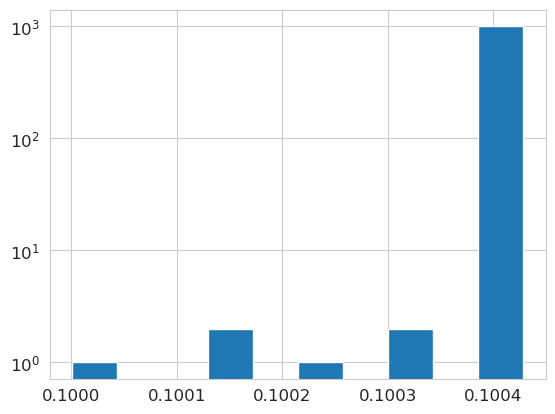

In [163]:
cdf_Nxn1 = np.cumsum(p_Nxn1, axis=1)
qidx_N = np.sum(cdf_Nxn1 < 1 - 0.9, axis=1)
plt.hist([cdf_Nxn1[i, j] for i, j in zip(range(N), qidx_N)], log=True);

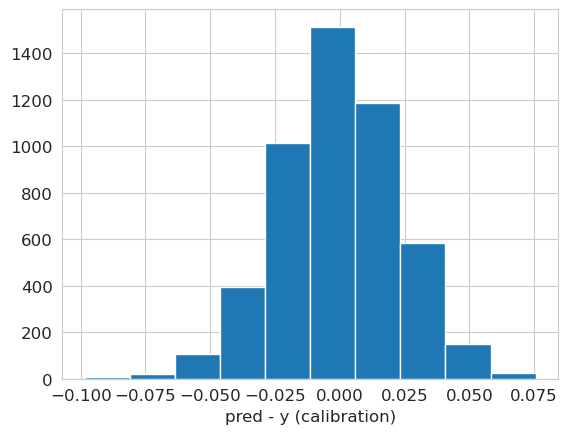

In [67]:
plt.hist(scores_n);
plt.xlabel('pred - y (calibration)');

# sandbox run_pp_selection_experiments

In [2]:
# cannot contain any groups that don't have any data from name2designdata
# MDRE.fit() will throw error
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
    'adalead-ff-0.\d',
    'adalead-cnn-0.\d',
    'biswas-ridge-0.\d',
    'biswas-ff-0.\d',
    'biswas-cnn-0.\d',
    'dbas-ff-0.\d',
    'dbas-cnn-0.\d',
    'pex-ridge',
    'pex-ff',
    'pex-cnn',
    'dbas-ridge-0.1t\d',
    'dbas-ridge-0.2t\d',
    'cbas-ridge-0.1t\d',
    'cbas-ridge-0.2t\d',
    'cbas-ridge-0.3t\d',
    'cbas-ridge-0.4t\d',
    'cbas-ridge-0.5t\d',
    'cbas-ridge-0.6t\d',
    'cbas-ridge-0.7t\d',
    'cbas-ridge-0.8t\d',
    'cbas-ridge-0.9t\d',
    'cbas-ff-0.1',
    'cbas-ff-0.2',
    'cbas-ff-0.3',
    'cbas-ff-0.4',
    'cbas-ff-0.5',
    'cbas-ff-0.6',
    'cbas-ff-0.7',
    'cbas-ff-0.8',
    'cbas-ff-0.9',
    'cbas-cnn-0.1',
    'cbas-cnn-0.2',
    'cbas-cnn-0.3',
    'cbas-cnn-0.4',
    'cbas-cnn-0.5',
    'cbas-cnn-0.6',
    'cbas-cnn-0.7',
    'cbas-cnn-0.8',
    'cbas-cnn-0.9',
    'vae-ridge'
]

In [ ]:
reload(dre)
reload(utils)
reload(rna)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01] # [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
# cbas ridge
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    design_names.append(f'cbas-ridge-{q}t19')

# dbas ridge
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
    

design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
cal_pkl_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'
target_values = np.arange(0.25, 0.501, 0.001)
n_trial = 200
n_mdre_hidden = 128
n_mdre_epoch = 100
use_quadratic_layer_mdre = True
n_forecast_designs = 1000
pp_csv_fname = '/data/wongfanc/rna-results/selection-pp-121624.csv'
cp_csv_fname = '/data/wongfanc/rna-results/selection-cp-121624.csv'
device = torch.device('cuda')

df = rna.run_pp_selection_experiments(
    design_names,
    design_pkl_fname,
    model_and_data_fname_no_ftype,
    cal_pkl_fname,
    mdre_group_regex_strs,
    target_values,
    n_trial,
    n_forecast_designs=n_forecast_designs,
    use_quadratic_layer_mdre=use_quadratic_layer_mdre,
    n_mdre_hidden=n_mdre_hidden,
    n_mdre_epoch=n_mdre_epoch,
    pp_csv_fname=pp_csv_fname,
    cp_csv_fname=cp_csv_fname,
    device=device,
)

No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.7t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.8t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.9t0, exiting MDRE select_intermediate_iterations.
All design names in provided design data:
cbas-ridge-0.1t19
cbas-ridge-0.2t19
cbas-ridge-0.3t19
cbas-ridge-0.4t19
cbas-ridge-0.5t19
cbas-ridge-0.6t19
cbas-ridge-0.7t19
cbas-ridge-0.8t19
cbas-ridge-0.9t19
dbas-ridge-0.1t19
dbas-ridge-0.2t19
adalead-ridge-0.5
adalead-ridge-0.4
adalead-ridge-0.3
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
pex-ridge
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
ada

100%|████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.30it/s]


Min train loss 0.72, min val loss 0.68

Fitting MDRE for adalead-ff-0.\d, which has 5 design algorithms:
train
adalead-ff-0.2
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
adalead-ff-0.15
One-hot-encoding all 6 categories of sequences...
  Done. (4 s)


100%|████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.32it/s]


Min train loss 0.66, min val loss 0.63

Fitting MDRE for adalead-cnn-0.\d, which has 5 design algorithms:
train
adalead-cnn-0.2
adalead-cnn-0.1
adalead-cnn-0.05
adalead-cnn-0.01
adalead-cnn-0.15
One-hot-encoding all 6 categories of sequences...
  Done. (4 s)


100%|████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.29it/s]


Min train loss 0.61, min val loss 0.57

Fitting MDRE for biswas-ridge-0.\d, which has 4 design algorithms:
train
biswas-ridge-0.02
biswas-ridge-0.01
biswas-ridge-0.005
biswas-ridge-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.50it/s]


Min train loss 1.00, min val loss 1.03

Fitting MDRE for biswas-ff-0.\d, which has 4 design algorithms:
train
biswas-ff-0.02
biswas-ff-0.01
biswas-ff-0.005
biswas-ff-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.40it/s]


Min train loss 1.00, min val loss 1.03

Fitting MDRE for biswas-cnn-0.\d, which has 4 design algorithms:
train
biswas-cnn-0.02
biswas-cnn-0.01
biswas-cnn-0.005
biswas-cnn-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.48it/s]


Min train loss 1.04, min val loss 1.06

Fitting MDRE for dbas-ff-0.\d, which has 9 design algorithms:
train
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
dbas-ff-0.7
dbas-ff-0.8
dbas-ff-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (7 s)


100%|████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


Min train loss 1.65, min val loss 1.59

Fitting MDRE for dbas-cnn-0.\d, which has 9 design algorithms:
train
dbas-cnn-0.1
dbas-cnn-0.2
dbas-cnn-0.3
dbas-cnn-0.4
dbas-cnn-0.5
dbas-cnn-0.6
dbas-cnn-0.7
dbas-cnn-0.8
dbas-cnn-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (7 s)


100%|████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.64it/s]


Min train loss 1.75, min val loss 1.69

Fitting MDRE for pex-ridge, which has 1 design algorithms:
train
pex-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.56it/s]


Min train loss 0.26, min val loss 0.30

Fitting MDRE for pex-ff, which has 1 design algorithms:
train
pex-ff
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.31it/s]


Min train loss 0.26, min val loss 0.31

Fitting MDRE for pex-cnn, which has 1 design algorithms:
train
pex-cnn
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.20it/s]


Min train loss 0.30, min val loss 0.30

Fitting MDRE for dbas-ridge-0.1t\d, which has 1 design algorithms:
train
dbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.27it/s]


Min train loss 0.47, min val loss 0.52

Fitting MDRE for dbas-ridge-0.2t\d, which has 1 design algorithms:
train
dbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.97it/s]


Min train loss 0.04, min val loss 0.06

Fitting MDRE for cbas-ridge-0.1t\d, which has 1 design algorithms:
train
cbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.97it/s]


Min train loss 0.60, min val loss 0.64

Fitting MDRE for cbas-ridge-0.2t\d, which has 1 design algorithms:
train
cbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.26it/s]


Min train loss 0.57, min val loss 0.63

Fitting MDRE for cbas-ridge-0.3t\d, which has 1 design algorithms:
train
cbas-ridge-0.3t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.39it/s]


Min train loss 0.57, min val loss 0.62

Fitting MDRE for cbas-ridge-0.4t\d, which has 1 design algorithms:
train
cbas-ridge-0.4t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.56it/s]


Min train loss 0.52, min val loss 0.57

Fitting MDRE for cbas-ridge-0.5t\d, which has 1 design algorithms:
train
cbas-ridge-0.5t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.40it/s]


Min train loss 0.51, min val loss 0.56

Fitting MDRE for cbas-ridge-0.6t\d, which has 1 design algorithms:
train
cbas-ridge-0.6t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.38it/s]


Min train loss 0.46, min val loss 0.51

Fitting MDRE for cbas-ridge-0.7t\d, which has 1 design algorithms:
train
cbas-ridge-0.7t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.67it/s]


Min train loss 0.38, min val loss 0.42

Fitting MDRE for cbas-ridge-0.8t\d, which has 1 design algorithms:
train
cbas-ridge-0.8t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.48it/s]


Min train loss 0.21, min val loss 0.27

Fitting MDRE for cbas-ridge-0.9t\d, which has 1 design algorithms:
train
cbas-ridge-0.9t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.93it/s]


Min train loss 0.02, min val loss 0.02

Fitting MDRE for cbas-ff-0.1, which has 1 design algorithms:
train
cbas-ff-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.24it/s]


Min train loss 0.59, min val loss 0.68

Fitting MDRE for cbas-ff-0.2, which has 1 design algorithms:
train
cbas-ff-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.14it/s]


Min train loss 0.61, min val loss 0.68

Fitting MDRE for cbas-ff-0.3, which has 1 design algorithms:
train
cbas-ff-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.26it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-ff-0.4, which has 1 design algorithms:
train
cbas-ff-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.54it/s]


Min train loss 0.61, min val loss 0.68

Fitting MDRE for cbas-ff-0.5, which has 1 design algorithms:
train
cbas-ff-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.53it/s]


Min train loss 0.61, min val loss 0.68

Fitting MDRE for cbas-ff-0.6, which has 1 design algorithms:
train
cbas-ff-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.51it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-ff-0.7, which has 1 design algorithms:
train
cbas-ff-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.56it/s]


Min train loss 0.59, min val loss 0.67

Fitting MDRE for cbas-ff-0.8, which has 1 design algorithms:
train
cbas-ff-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.88it/s]


Min train loss 0.60, min val loss 0.67

Fitting MDRE for cbas-ff-0.9, which has 1 design algorithms:
train
cbas-ff-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.64it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-cnn-0.1, which has 1 design algorithms:
train
cbas-cnn-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.65it/s]


Min train loss 0.62, min val loss 0.67

Fitting MDRE for cbas-cnn-0.2, which has 1 design algorithms:
train
cbas-cnn-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.37it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-cnn-0.3, which has 1 design algorithms:
train
cbas-cnn-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.63it/s]


Min train loss 0.61, min val loss 0.66

Fitting MDRE for cbas-cnn-0.4, which has 1 design algorithms:
train
cbas-cnn-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.50it/s]


Min train loss 0.62, min val loss 0.67

Fitting MDRE for cbas-cnn-0.5, which has 1 design algorithms:
train
cbas-cnn-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.73it/s]


Min train loss 0.61, min val loss 0.69

Fitting MDRE for cbas-cnn-0.6, which has 1 design algorithms:
train
cbas-cnn-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.43it/s]


Min train loss 0.61, min val loss 0.68

Fitting MDRE for cbas-cnn-0.7, which has 1 design algorithms:
train
cbas-cnn-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.35it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for cbas-cnn-0.8, which has 1 design algorithms:
train
cbas-cnn-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.17it/s]


Min train loss 0.62, min val loss 0.68

Fitting MDRE for cbas-cnn-0.9, which has 1 design algorithms:
train
cbas-cnn-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.43it/s]


Min train loss 0.61, min val loss 0.67

Fitting MDRE for vae-ridge, which has 1 design algorithms:
train
vae-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.58it/s]


Min train loss 0.65, min val loss 0.69

Done estimating density ratios for all design sequences. (155 s)
vae-ridge has LBs 0.3348, 0.3348
cbas-ridge-0.1t19 has LBs 0.2744, 0.3267
cbas-ridge-0.2t19 has LBs 0.2691, 0.2691
cbas-ridge-0.3t19 has LBs 0.2959, 0.2959
cbas-ridge-0.4t19 has LBs 0.3215, 0.3215
cbas-ridge-0.5t19 has LBs 0.2796, 0.2796
cbas-ridge-0.6t19 has LBs 0.2879, 0.2879
cbas-ridge-0.7t19 has LBs 0.2976, 0.2976
cbas-ridge-0.8t19 has LBs 0.3166, 0.3166
cbas-ridge-0.9t19 has LBs 0.4073, 0.4073
dbas-ridge-0.1t19 has LBs 0.3057, 0.3057
dbas-ridge-0.2t19 has LBs 0.3618, 0.3618
adalead-ridge-0.2 has LBs 0.3549, 0.3696
adalead-ridge-0.15 has LBs 0.3771, 0.3794
adalead-ridge-0.1 has LBs 0.3842, 0.3842
adalead-ridge-0.05 has LBs 0.4029, 0.4029
adalead-ridge-0.01 has LBs 0.3994, 0.3994
biswas-ridge-0.02 has LBs 0.3356, 0.3356
biswas-ridge-0.015 has LBs 0.3162, 0.3412
biswas-ridge-0.01 has LBs 0.3429, 0.3429
biswas-ridge-0.005 has LBs 0.3271, 0.3579
pex-ridge has LBs 0.4076, 0.4076
adal

biswas-cnn-0.005 has LBs 0.3163, 0.3523
pex-cnn has LBs 0.3733, 0.3733
cbas-cnn-0.1 has LBs -inf, 0.3120
cbas-cnn-0.2 has LBs 0.2579, 0.2812
cbas-cnn-0.3 has LBs 0.2950, 0.2950
cbas-cnn-0.4 has LBs 0.3061, 0.3061
cbas-cnn-0.5 has LBs 0.3026, 0.3026
cbas-cnn-0.6 has LBs 0.2715, 0.2715
cbas-cnn-0.7 has LBs 0.3075, 0.3075
cbas-cnn-0.8 has LBs 0.3284, 0.3284
cbas-cnn-0.9 has LBs 0.2815, 0.2815
dbas-cnn-0.2 has LBs 0.3098, 0.3229
dbas-cnn-0.3 has LBs 0.2702, 0.3018
dbas-cnn-0.4 has LBs 0.3136, 0.3136
dbas-cnn-0.5 has LBs 0.3491, 0.3491
dbas-cnn-0.6 has LBs 0.2956, 0.2956
dbas-cnn-0.7 has LBs 0.2952, 0.3074
dbas-cnn-0.8 has LBs 0.3718, 0.3718
dbas-cnn-0.9 has LBs 0.3381, 0.3381
Done running 3 / 200 trials (851 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (852 s).

vae-ridge has LBs 0.2959, 0.2959
cbas-ridge-0.1t19 has LBs 0.2634, 0.2634
cbas-ridge-0.2t19 has LBs 0.2857, 0.2857
cbas-ridge-0.3t19 has LBs 0.2704, 0.2785
c

cbas-ff-0.5 has LBs 0.3006, 0.3006
cbas-ff-0.6 has LBs 0.2869, 0.2869
cbas-ff-0.7 has LBs 0.3143, 0.3143
cbas-ff-0.8 has LBs 0.2941, 0.2941
dbas-ff-0.1 has LBs 0.2639, 0.2639
dbas-ff-0.2 has LBs 0.2980, 0.2980
dbas-ff-0.3 has LBs 0.3022, 0.3022
dbas-ff-0.4 has LBs 0.3081, 0.3081
dbas-ff-0.5 has LBs 0.2868, 0.3390
dbas-ff-0.6 has LBs 0.3279, 0.3279
dbas-ff-0.7 has LBs 0.3066, 0.3204
dbas-ff-0.8 has LBs 0.3307, 0.3307
dbas-ff-0.9 has LBs 0.3269, 0.3269
adalead-cnn-0.2 has LBs 0.3275, 0.3275
adalead-cnn-0.15 has LBs -inf, 0.3348
adalead-cnn-0.1 has LBs 0.3400, 0.3730
adalead-cnn-0.05 has LBs 0.3545, 0.3792
adalead-cnn-0.01 has LBs 0.3585, 0.3585
biswas-cnn-0.02 has LBs 0.2789, 0.2789
biswas-cnn-0.015 has LBs 0.2929, 0.2929
biswas-cnn-0.01 has LBs -inf, 0.3053
biswas-cnn-0.005 has LBs 0.3984, 0.3984
pex-cnn has LBs 0.2930, 0.3255
cbas-cnn-0.1 has LBs 0.2181, 0.2181
cbas-cnn-0.2 has LBs 0.2958, 0.2958
cbas-cnn-0.3 has LBs 0.2812, 0.3093
cbas-cnn-0.4 has LBs 0.2857, 0.3054
cbas-cnn-0.5 has L

biswas-ridge-0.02 has LBs 0.2977, 0.2977
biswas-ridge-0.015 has LBs 0.3240, 0.3436
biswas-ridge-0.01 has LBs 0.3451, 0.3451
biswas-ridge-0.005 has LBs 0.3620, 0.3627
pex-ridge has LBs 0.3175, 0.3175
adalead-ff-0.2 has LBs 0.3593, 0.3593
adalead-ff-0.15 has LBs 0.3669, 0.3669
adalead-ff-0.1 has LBs 0.3753, 0.3753
adalead-ff-0.05 has LBs 0.3917, 0.3917
adalead-ff-0.01 has LBs 0.3874, 0.3898
biswas-ff-0.02 has LBs 0.3469, 0.3469
biswas-ff-0.015 has LBs 0.3576, 0.3576
biswas-ff-0.01 has LBs 0.3500, 0.3749
biswas-ff-0.005 has LBs 0.3554, 0.3554
pex-ff has LBs 0.3139, 0.3139
cbas-ff-0.1 has LBs 0.3127, 0.3127
cbas-ff-0.2 has LBs 0.2684, 0.2684
cbas-ff-0.3 has LBs 0.2804, 0.2804
cbas-ff-0.4 has LBs 0.2791, 0.2791
cbas-ff-0.5 has LBs 0.2695, 0.2695
cbas-ff-0.6 has LBs 0.2608, 0.2822
cbas-ff-0.8 has LBs 0.2714, 0.2714
cbas-ff-0.9 has LBs 0.2721, 0.2721
dbas-ff-0.1 has LBs 0.2819, 0.2863
dbas-ff-0.2 has LBs 0.2882, 0.2882
dbas-ff-0.3 has LBs 0.2895, 0.2910
dbas-ff-0.4 has LBs 0.3186, 0.3186
dbas

dbas-cnn-0.9 has LBs 0.2928, 0.2928
Done running 11 / 200 trials (3127 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (3128 s).

vae-ridge has LBs 0.2239, 0.2239
cbas-ridge-0.1t19 has LBs 0.2743, 0.2743
cbas-ridge-0.2t19 has LBs 0.2967, 0.2967
cbas-ridge-0.3t19 has LBs 0.2878, 0.2878
cbas-ridge-0.4t19 has LBs 0.2899, 0.2899
cbas-ridge-0.5t19 has LBs 0.2476, 0.2476
cbas-ridge-0.6t19 has LBs 0.2445, 0.2445
cbas-ridge-0.7t19 has LBs 0.3138, 0.3138
cbas-ridge-0.8t19 has LBs 0.3860, 0.3860
cbas-ridge-0.9t19 has LBs 0.3779, 0.4239
dbas-ridge-0.1t19 has LBs 0.2808, 0.2808
dbas-ridge-0.2t19 has LBs 0.3529, 0.4142
adalead-ridge-0.15 has LBs 0.3731, 0.3731
adalead-ridge-0.1 has LBs 0.3984, 0.4024
adalead-ridge-0.05 has LBs 0.4471, 0.4490
adalead-ridge-0.01 has LBs 0.3905, 0.4427
biswas-ridge-0.02 has LBs 0.2861, 0.3094
biswas-ridge-0.015 has LBs 0.3075, 0.3075
biswas-ridge-0.01 has LBs 0.3161, 0.3542
biswas-ridge-0.005 has L

biswas-cnn-0.01 has LBs 0.3271, 0.3724
biswas-cnn-0.005 has LBs 0.3468, 0.3492
pex-cnn has LBs 0.3185, 0.3185
cbas-cnn-0.1 has LBs 0.2720, 0.2720
cbas-cnn-0.2 has LBs 0.2680, 0.2680
cbas-cnn-0.3 has LBs -inf, 0.2334
cbas-cnn-0.4 has LBs 0.2839, 0.2839
cbas-cnn-0.6 has LBs 0.2970, 0.2970
cbas-cnn-0.7 has LBs 0.2682, 0.2682
cbas-cnn-0.8 has LBs 0.2703, 0.2860
cbas-cnn-0.9 has LBs 0.2159, 0.2159
dbas-cnn-0.1 has LBs 0.3079, 0.3079
dbas-cnn-0.2 has LBs 0.2644, 0.2644
dbas-cnn-0.3 has LBs 0.2549, 0.3212
dbas-cnn-0.4 has LBs 0.2926, 0.2926
dbas-cnn-0.5 has LBs 0.3258, 0.3900
dbas-cnn-0.6 has LBs 0.3135, 0.3241
dbas-cnn-0.7 has LBs 0.3030, 0.3030
dbas-cnn-0.8 has LBs 0.3142, 0.3142
dbas-cnn-0.9 has LBs 0.2999, 0.2999
Done running 14 / 200 trials (3953 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (3955 s).

vae-ridge has LBs 0.2982, 0.2982
cbas-ridge-0.1t19 has LBs 0.2871, 0.2871
cbas-ridge-0.2t19 has LBs 0.2783, 0.2783


cbas-ff-0.5 has LBs 0.2870, 0.2870
cbas-ff-0.6 has LBs 0.2868, 0.2868
cbas-ff-0.7 has LBs 0.2502, 0.2956
cbas-ff-0.8 has LBs 0.2513, 0.2513
cbas-ff-0.9 has LBs 0.3139, 0.3139
dbas-ff-0.1 has LBs 0.2801, 0.2944
dbas-ff-0.2 has LBs 0.2937, 0.2937
dbas-ff-0.3 has LBs 0.3409, 0.3409
dbas-ff-0.4 has LBs 0.2886, 0.2886
dbas-ff-0.5 has LBs 0.3335, 0.3335
dbas-ff-0.6 has LBs 0.3099, 0.3584
dbas-ff-0.7 has LBs 0.3764, 0.3764
dbas-ff-0.8 has LBs 0.3115, 0.3115
dbas-ff-0.9 has LBs 0.3508, 0.3508
adalead-cnn-0.2 has LBs 0.2960, 0.3255
adalead-cnn-0.1 has LBs 0.3390, 0.3925
adalead-cnn-0.05 has LBs 0.3505, 0.3915
adalead-cnn-0.01 has LBs 0.3555, 0.4090
biswas-cnn-0.02 has LBs 0.2839, 0.2839
biswas-cnn-0.015 has LBs 0.2917, 0.3211
biswas-cnn-0.01 has LBs 0.3335, 0.3335
biswas-cnn-0.005 has LBs 0.3262, 0.3262
pex-cnn has LBs 0.2986, 0.2986
cbas-cnn-0.1 has LBs 0.2885, 0.2885
cbas-cnn-0.2 has LBs 0.2825, 0.2825
cbas-cnn-0.3 has LBs 0.2669, 0.2669
cbas-cnn-0.4 has LBs 0.2499, 0.2499
cbas-cnn-0.5 has LB

adalead-ridge-0.05 has LBs 0.3713, 0.4689
adalead-ridge-0.01 has LBs 0.3673, 0.4090
biswas-ridge-0.02 has LBs 0.3677, 0.3677
biswas-ridge-0.015 has LBs 0.3623, 0.3623
biswas-ridge-0.01 has LBs 0.3544, 0.4104
biswas-ridge-0.005 has LBs 0.3931, 0.4283
adalead-ff-0.2 has LBs 0.3586, 0.3742
adalead-ff-0.15 has LBs 0.3664, 0.3820
adalead-ff-0.1 has LBs 0.3761, 0.3761
adalead-ff-0.05 has LBs 0.3867, 0.4559
adalead-ff-0.01 has LBs 0.3592, 0.4001
biswas-ff-0.02 has LBs 0.3511, 0.3864
biswas-ff-0.015 has LBs 0.3975, 0.3975
biswas-ff-0.01 has LBs 0.4139, 0.4139
biswas-ff-0.005 has LBs 0.4330, 0.4330
pex-ff has LBs 0.3947, 0.3947
cbas-ff-0.1 has LBs 0.2863, 0.2863
cbas-ff-0.2 has LBs 0.3428, 0.3428
cbas-ff-0.3 has LBs 0.3424, 0.3424
cbas-ff-0.4 has LBs 0.2565, 0.2565
cbas-ff-0.5 has LBs 0.2890, 0.2890
cbas-ff-0.6 has LBs 0.3418, 0.3418
cbas-ff-0.7 has LBs 0.2924, 0.2924
cbas-ff-0.8 has LBs 0.2745, 0.2920
cbas-ff-0.9 has LBs 0.2654, 0.2654
dbas-ff-0.1 has LBs 0.2815, 0.2815
dbas-ff-0.2 has LBs 0.2

Done running 22 / 200 trials (6252 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (6254 s).

vae-ridge has LBs 0.2418, 0.2418
cbas-ridge-0.1t19 has LBs 0.2907, 0.3002
cbas-ridge-0.2t19 has LBs 0.3146, 0.3146
cbas-ridge-0.3t19 has LBs 0.2868, 0.2868
cbas-ridge-0.4t19 has LBs 0.2862, 0.2862
cbas-ridge-0.5t19 has LBs 0.3416, 0.3416
cbas-ridge-0.6t19 has LBs 0.3078, 0.3078
cbas-ridge-0.7t19 has LBs 0.3402, 0.3402
cbas-ridge-0.8t19 has LBs 0.3663, 0.3663
cbas-ridge-0.9t19 has LBs 0.3800, 0.4153
dbas-ridge-0.1t19 has LBs 0.2784, 0.2784
dbas-ridge-0.2t19 has LBs 0.3323, 0.3866
adalead-ridge-0.1 has LBs 0.3414, 0.3414
adalead-ridge-0.05 has LBs 0.3559, 0.3559
adalead-ridge-0.01 has LBs 0.3516, 0.3516
biswas-ridge-0.02 has LBs 0.2694, 0.2694
biswas-ridge-0.015 has LBs 0.2992, 0.2992
biswas-ridge-0.01 has LBs 0.3177, 0.3177
biswas-ridge-0.005 has LBs 0.4226, 0.4226
pex-ridge has LBs 0.3777, 0.3777
adalead-ff-0.2 has LBs 0.31

biswas-cnn-0.02 has LBs 0.2797, 0.2797
biswas-cnn-0.015 has LBs 0.2870, 0.2870
biswas-cnn-0.005 has LBs 0.3262, 0.3713
pex-cnn has LBs 0.2915, 0.3124
cbas-cnn-0.1 has LBs 0.2841, 0.2841
cbas-cnn-0.2 has LBs 0.2846, 0.2846
cbas-cnn-0.3 has LBs 0.2378, 0.2378
cbas-cnn-0.4 has LBs 0.3036, 0.3036
cbas-cnn-0.5 has LBs 0.3074, 0.3074
cbas-cnn-0.6 has LBs 0.3122, 0.3148
cbas-cnn-0.7 has LBs 0.2850, 0.2850
cbas-cnn-0.8 has LBs 0.3208, 0.3208
cbas-cnn-0.9 has LBs 0.2854, 0.2854
dbas-cnn-0.1 has LBs 0.2480, 0.2480
dbas-cnn-0.2 has LBs 0.2973, 0.2973
dbas-cnn-0.3 has LBs 0.2838, 0.3081
dbas-cnn-0.4 has LBs 0.3173, 0.3185
dbas-cnn-0.5 has LBs 0.3373, 0.3373
dbas-cnn-0.6 has LBs 0.2754, 0.3623
dbas-cnn-0.7 has LBs 0.3248, 0.3248
dbas-cnn-0.8 has LBs 0.3270, 0.3270
dbas-cnn-0.9 has LBs 0.2837, 0.2837
Done running 25 / 200 trials (7092 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (7094 s).

vae-ridge has LBs 0.2960, 0.2960
cbas

biswas-ff-0.005 has LBs 0.3289, 0.3289
pex-ff has LBs 0.3538, 0.3538
cbas-ff-0.1 has LBs 0.3454, 0.3454
cbas-ff-0.3 has LBs 0.2904, 0.2904
cbas-ff-0.4 has LBs 0.2867, 0.2867
cbas-ff-0.6 has LBs 0.2842, 0.2842
cbas-ff-0.7 has LBs 0.3151, 0.3496
cbas-ff-0.8 has LBs 0.2720, 0.2720
cbas-ff-0.9 has LBs 0.2421, 0.2860
dbas-ff-0.1 has LBs 0.2801, 0.2801
dbas-ff-0.2 has LBs 0.2771, 0.2771
dbas-ff-0.3 has LBs 0.2799, 0.2799
dbas-ff-0.4 has LBs 0.2902, 0.3187
dbas-ff-0.5 has LBs 0.3339, 0.3380
dbas-ff-0.6 has LBs 0.3470, 0.3943
dbas-ff-0.7 has LBs 0.3823, 0.3823
dbas-ff-0.8 has LBs 0.2960, 0.2960
dbas-ff-0.9 has LBs 0.3666, 0.4017
adalead-cnn-0.2 has LBs 0.3060, 0.3060
adalead-cnn-0.15 has LBs 0.3128, 0.3128
adalead-cnn-0.1 has LBs 0.3186, 0.3556
adalead-cnn-0.05 has LBs 0.3184, 0.3588
biswas-cnn-0.02 has LBs 0.3107, 0.3148
biswas-cnn-0.015 has LBs 0.2682, 0.3230
biswas-cnn-0.01 has LBs 0.2838, 0.3328
biswas-cnn-0.005 has LBs 0.3058, 0.3548
pex-cnn has LBs 0.2955, 0.2955
cbas-cnn-0.1 has LBs 0.3

adalead-ridge-0.2 has LBs 0.3273, 0.3550
adalead-ridge-0.15 has LBs 0.3392, 0.3644
adalead-ridge-0.1 has LBs 0.3463, 0.3537
adalead-ridge-0.05 has LBs 0.3619, 0.3619
adalead-ridge-0.01 has LBs 0.4183, 0.4239
biswas-ridge-0.02 has LBs 0.3312, 0.4118
biswas-ridge-0.015 has LBs 0.3312, 0.4219
biswas-ridge-0.01 has LBs 0.3523, 0.3523
biswas-ridge-0.005 has LBs 0.3268, 0.3589
pex-ridge has LBs 0.3416, 0.3416
adalead-ff-0.2 has LBs 0.3229, 0.3765
adalead-ff-0.15 has LBs 0.3295, 0.3831
adalead-ff-0.1 has LBs 0.3401, 0.3468
adalead-ff-0.05 has LBs 0.3556, 0.4092
adalead-ff-0.01 has LBs 0.3763, 0.3856
biswas-ff-0.02 has LBs 0.3179, 0.3482
biswas-ff-0.015 has LBs 0.3594, 0.3594
biswas-ff-0.01 has LBs 0.3763, 0.3763
biswas-ff-0.005 has LBs 0.3496, 0.3678
pex-ff has LBs 0.3111, 0.3111
cbas-ff-0.1 has LBs 0.2946, 0.2946
cbas-ff-0.2 has LBs 0.2908, 0.2908
cbas-ff-0.3 has LBs 0.2964, 0.3062
cbas-ff-0.4 has LBs 0.2510, 0.2510
cbas-ff-0.5 has LBs 0.2519, 0.2519
cbas-ff-0.6 has LBs 0.2965, 0.2965
cbas-f

dbas-cnn-0.6 has LBs 0.2967, 0.3023
dbas-cnn-0.7 has LBs 0.2893, 0.3016
dbas-cnn-0.8 has LBs 0.3168, 0.3427
dbas-cnn-0.9 has LBs 0.2934, 0.2934
Done running 33 / 200 trials (9406 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (9408 s).

vae-ridge has LBs 0.2983, 0.2983
cbas-ridge-0.1t19 has LBs 0.3495, 0.3495
cbas-ridge-0.2t19 has LBs 0.3230, 0.3230
cbas-ridge-0.3t19 has LBs 0.2507, 0.2692
cbas-ridge-0.4t19 has LBs 0.3219, 0.3219
cbas-ridge-0.5t19 has LBs 0.2965, 0.2965
cbas-ridge-0.6t19 has LBs 0.2879, 0.2879
cbas-ridge-0.7t19 has LBs 0.2490, 0.2490
cbas-ridge-0.8t19 has LBs 0.3110, 0.3110
cbas-ridge-0.9t19 has LBs 0.4106, 0.4121
dbas-ridge-0.1t19 has LBs 0.2790, 0.2790
dbas-ridge-0.2t19 has LBs 0.3810, 0.4300
adalead-ridge-0.2 has LBs 0.3185, 0.3590
adalead-ridge-0.15 has LBs 0.3456, 0.3671
adalead-ridge-0.1 has LBs 0.3748, 0.4304
adalead-ridge-0.01 has LBs 0.3864, 0.4420
biswas-ridge-0.02 has LBs 0.3500, 0.3500


adalead-cnn-0.2 has LBs 0.3336, 0.3572
adalead-cnn-0.15 has LBs 0.3400, 0.3635
adalead-cnn-0.1 has LBs 0.3462, 0.3697
adalead-cnn-0.05 has LBs 0.3798, 0.3843
adalead-cnn-0.01 has LBs 0.3823, 0.3867
biswas-cnn-0.02 has LBs 0.3543, 0.3543
biswas-cnn-0.015 has LBs 0.3228, 0.3228
biswas-cnn-0.01 has LBs 0.3355, 0.3355
biswas-cnn-0.005 has LBs 0.3575, 0.3575
pex-cnn has LBs 0.2923, 0.2923
cbas-cnn-0.1 has LBs 0.2604, 0.2604
cbas-cnn-0.2 has LBs 0.3351, 0.3351
cbas-cnn-0.3 has LBs 0.3324, 0.3611
cbas-cnn-0.4 has LBs 0.2990, 0.2990
cbas-cnn-0.5 has LBs 0.2511, 0.2511
cbas-cnn-0.6 has LBs 0.2922, 0.2922
cbas-cnn-0.7 has LBs 0.2853, 0.2853
cbas-cnn-0.8 has LBs 0.3346, 0.3346
cbas-cnn-0.9 has LBs 0.2997, 0.2997
dbas-cnn-0.1 has LBs 0.3336, 0.3336
dbas-cnn-0.2 has LBs 0.2752, 0.2752
dbas-cnn-0.3 has LBs 0.2844, 0.2844
dbas-cnn-0.4 has LBs 0.2388, 0.2388
dbas-cnn-0.5 has LBs 0.3111, 0.3111
dbas-cnn-0.6 has LBs 0.2759, 0.2937
dbas-cnn-0.7 has LBs 0.3061, 0.3061
dbas-cnn-0.8 has LBs 0.3132, 0.3132
d

pex-ff has LBs 0.3038, 0.3038
cbas-ff-0.1 has LBs 0.2785, 0.2785
cbas-ff-0.2 has LBs 0.3097, 0.3097
cbas-ff-0.3 has LBs 0.3024, 0.3024
cbas-ff-0.4 has LBs 0.3072, 0.3072
cbas-ff-0.5 has LBs 0.2803, 0.3012
cbas-ff-0.6 has LBs 0.3065, 0.3065
cbas-ff-0.7 has LBs 0.3048, 0.3048
cbas-ff-0.8 has LBs 0.3343, 0.3343
cbas-ff-0.9 has LBs 0.2527, 0.2527
dbas-ff-0.1 has LBs -inf, 0.2691
dbas-ff-0.2 has LBs 0.3255, 0.3255
dbas-ff-0.3 has LBs 0.2854, 0.3495
dbas-ff-0.4 has LBs 0.2937, 0.2937
dbas-ff-0.5 has LBs 0.3310, 0.3310
dbas-ff-0.6 has LBs 0.3031, 0.3031
dbas-ff-0.7 has LBs 0.3236, 0.3236
dbas-ff-0.8 has LBs 0.3136, 0.3136
dbas-ff-0.9 has LBs 0.3359, 0.3982
adalead-cnn-0.2 has LBs 0.3156, 0.3389
adalead-cnn-0.15 has LBs 0.3248, 0.3460
adalead-cnn-0.1 has LBs 0.3305, 0.3517
adalead-cnn-0.05 has LBs 0.3659, 0.3659
adalead-cnn-0.01 has LBs -inf, 0.3478
biswas-cnn-0.02 has LBs 0.2883, 0.3109
biswas-cnn-0.015 has LBs 0.3033, 0.3033
biswas-cnn-0.01 has LBs -inf, 0.3164
biswas-cnn-0.005 has LBs 0.338

cbas-ridge-0.8t19 has LBs 0.3249, 0.3408
cbas-ridge-0.9t19 has LBs 0.4234, 0.4234
dbas-ridge-0.1t19 has LBs 0.3116, 0.3116
dbas-ridge-0.2t19 has LBs 0.3494, 0.3494
adalead-ridge-0.2 has LBs 0.3801, 0.3822
adalead-ridge-0.15 has LBs 0.3903, 0.3925
adalead-ridge-0.1 has LBs 0.3977, 0.3998
adalead-ridge-0.05 has LBs 0.3719, 0.4120
adalead-ridge-0.01 has LBs 0.3683, 0.4083
biswas-ridge-0.02 has LBs 0.2982, 0.3187
biswas-ridge-0.01 has LBs 0.4297, 0.4297
biswas-ridge-0.005 has LBs 0.3297, 0.3771
pex-ridge has LBs 0.3316, 0.3316
adalead-ff-0.2 has LBs 0.3657, 0.3657
adalead-ff-0.15 has LBs 0.3755, 0.3755
adalead-ff-0.1 has LBs 0.3451, 0.3988
adalead-ff-0.05 has LBs 0.3623, 0.4002
adalead-ff-0.01 has LBs 0.3586, 0.3586
biswas-ff-0.02 has LBs 0.2957, 0.2957
biswas-ff-0.015 has LBs 0.3097, 0.3097
biswas-ff-0.01 has LBs 0.3248, 0.3248
biswas-ff-0.005 has LBs 0.3422, 0.3422
pex-ff has LBs 0.3387, 0.3387
cbas-ff-0.1 has LBs 0.2705, 0.2705
cbas-ff-0.2 has LBs 0.2981, 0.2981
cbas-ff-0.3 has LBs 0.33

cbas-cnn-0.8 has LBs 0.2714, 0.2714
cbas-cnn-0.9 has LBs 0.2716, 0.2880
dbas-cnn-0.1 has LBs 0.2982, 0.2982
dbas-cnn-0.2 has LBs 0.3070, 0.3070
dbas-cnn-0.3 has LBs 0.3125, 0.3544
dbas-cnn-0.4 has LBs -inf, 0.2992
dbas-cnn-0.5 has LBs 0.3479, 0.3688
dbas-cnn-0.6 has LBs 0.3470, 0.3470
dbas-cnn-0.7 has LBs -inf, 0.3440
dbas-cnn-0.8 has LBs 0.3084, 0.3084
dbas-cnn-0.9 has LBs 0.3094, 0.3094
Done running 44 / 200 trials (12601 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (12603 s).

vae-ridge has LBs 0.2655, 0.2655
cbas-ridge-0.2t19 has LBs 0.2698, 0.2698
cbas-ridge-0.3t19 has LBs 0.2708, 0.2708
cbas-ridge-0.4t19 has LBs 0.2792, 0.2792
cbas-ridge-0.5t19 has LBs 0.2791, 0.2791
cbas-ridge-0.6t19 has LBs 0.3395, 0.3395
cbas-ridge-0.7t19 has LBs 0.3521, 0.3521
cbas-ridge-0.8t19 has LBs 0.3827, 0.3827
cbas-ridge-0.9t19 has LBs 0.4459, 0.4459
dbas-ridge-0.1t19 has LBs -inf, 0.2796
dbas-ridge-0.2t19 has LBs 0.4307, 0.4307


dbas-ff-0.8 has LBs 0.3342, 0.3342
dbas-ff-0.9 has LBs 0.3605, 0.3605
adalead-cnn-0.2 has LBs 0.3028, 0.3565
adalead-cnn-0.15 has LBs 0.3099, 0.3636
adalead-cnn-0.1 has LBs 0.3688, 0.3935
adalead-cnn-0.05 has LBs 0.3835, 0.3835
adalead-cnn-0.01 has LBs 0.3860, 0.3860
biswas-cnn-0.02 has LBs 0.3336, 0.3336
biswas-cnn-0.015 has LBs 0.2965, 0.3399
biswas-cnn-0.01 has LBs 0.2813, 0.3103
biswas-cnn-0.005 has LBs 0.3033, 0.3569
pex-cnn has LBs 0.2741, 0.2741
cbas-cnn-0.1 has LBs 0.2297, 0.2297
cbas-cnn-0.2 has LBs 0.3077, 0.3077
cbas-cnn-0.3 has LBs 0.2417, 0.2417
cbas-cnn-0.4 has LBs 0.2658, 0.3121
cbas-cnn-0.5 has LBs 0.3209, 0.3209
cbas-cnn-0.6 has LBs 0.2973, 0.2973
cbas-cnn-0.7 has LBs 0.2531, 0.2531
cbas-cnn-0.8 has LBs 0.2414, 0.2414
cbas-cnn-0.9 has LBs 0.2695, 0.2695
dbas-cnn-0.1 has LBs 0.2927, 0.2974
dbas-cnn-0.2 has LBs 0.2778, 0.2778
dbas-cnn-0.4 has LBs 0.2594, 0.2594
dbas-cnn-0.5 has LBs 0.3026, 0.3026
dbas-cnn-0.6 has LBs 0.2842, 0.2985
dbas-cnn-0.7 has LBs 0.2725, 0.3055
dba

adalead-ff-0.15 has LBs 0.3318, 0.3526
adalead-ff-0.1 has LBs 0.3604, 0.3604
adalead-ff-0.05 has LBs 0.3782, 0.3990
adalead-ff-0.01 has LBs 0.3752, 0.3752
biswas-ff-0.02 has LBs 0.3013, 0.3202
biswas-ff-0.015 has LBs 0.3256, 0.3305
biswas-ff-0.01 has LBs 0.3442, 0.3442
biswas-ff-0.005 has LBs 0.3623, 0.3623
pex-ff has LBs 0.3000, 0.3000
cbas-ff-0.1 has LBs 0.2812, 0.2812
cbas-ff-0.2 has LBs 0.2943, 0.2943
cbas-ff-0.3 has LBs 0.2515, 0.2515
cbas-ff-0.4 has LBs 0.2766, 0.2766
cbas-ff-0.5 has LBs 0.2758, 0.2758
cbas-ff-0.6 has LBs 0.3233, 0.3233
cbas-ff-0.7 has LBs 0.2960, 0.2960
cbas-ff-0.8 has LBs 0.2786, 0.2786
cbas-ff-0.9 has LBs 0.3147, 0.3199
dbas-ff-0.1 has LBs 0.2572, 0.2572
dbas-ff-0.2 has LBs 0.2854, 0.3051
dbas-ff-0.3 has LBs 0.2793, 0.3207
dbas-ff-0.4 has LBs 0.3036, 0.3046
dbas-ff-0.5 has LBs 0.3019, 0.3185
dbas-ff-0.6 has LBs 0.2870, 0.2870
dbas-ff-0.7 has LBs 0.3290, 0.3343
dbas-ff-0.8 has LBs 0.3159, 0.3159
dbas-ff-0.9 has LBs 0.3315, 0.3315
adalead-cnn-0.2 has LBs 0.3167,

cbas-ridge-0.5t19 has LBs 0.3285, 0.3285
cbas-ridge-0.6t19 has LBs 0.2822, 0.2822
cbas-ridge-0.7t19 has LBs 0.3495, 0.3495
cbas-ridge-0.8t19 has LBs 0.3700, 0.3700
cbas-ridge-0.9t19 has LBs 0.3871, 0.3969
dbas-ridge-0.1t19 has LBs 0.3292, 0.3292
dbas-ridge-0.2t19 has LBs 0.3410, 0.3410
adalead-ridge-0.2 has LBs 0.3328, 0.3633
adalead-ridge-0.15 has LBs -inf, 0.3721
adalead-ridge-0.1 has LBs 0.3497, 0.3497
adalead-ridge-0.05 has LBs 0.3947, 0.4481
adalead-ridge-0.01 has LBs 0.3612, 0.3918
biswas-ridge-0.02 has LBs 0.3742, 0.3742
biswas-ridge-0.015 has LBs 0.3149, 0.3353
biswas-ridge-0.01 has LBs 0.3199, 0.3338
biswas-ridge-0.005 has LBs 0.3523, 0.3790
pex-ridge has LBs 0.3173, 0.3305
adalead-ff-0.15 has LBs 0.3408, 0.3893
adalead-ff-0.1 has LBs -inf, 0.3636
adalead-ff-0.05 has LBs 0.4424, 0.4435
adalead-ff-0.01 has LBs 0.3616, 0.3863
biswas-ff-0.02 has LBs 0.2970, 0.2970
biswas-ff-0.015 has LBs 0.3095, 0.3095
biswas-ff-0.01 has LBs 0.3261, 0.3261
biswas-ff-0.005 has LBs 0.3540, 0.3540
p

cbas-cnn-0.5 has LBs 0.2373, 0.2373
cbas-cnn-0.6 has LBs 0.2951, 0.2951
cbas-cnn-0.7 has LBs 0.2901, 0.2901
cbas-cnn-0.8 has LBs 0.3296, 0.3296
cbas-cnn-0.9 has LBs 0.2639, 0.2639
dbas-cnn-0.1 has LBs 0.2690, 0.2690
dbas-cnn-0.2 has LBs 0.2534, 0.2534
dbas-cnn-0.3 has LBs 0.2775, 0.3045
dbas-cnn-0.4 has LBs 0.3076, 0.3183
dbas-cnn-0.5 has LBs 0.3496, 0.3496
dbas-cnn-0.6 has LBs 0.2864, 0.3171
dbas-cnn-0.7 has LBs 0.3353, 0.3353
dbas-cnn-0.8 has LBs 0.3268, 0.3268
dbas-cnn-0.9 has LBs 0.3240, 0.3240
Done running 55 / 200 trials (15757 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (15759 s).

vae-ridge has LBs 0.2066, 0.2066
cbas-ridge-0.1t19 has LBs 0.2839, 0.2839
cbas-ridge-0.2t19 has LBs -inf, 0.2838
cbas-ridge-0.3t19 has LBs 0.2856, 0.3281
cbas-ridge-0.4t19 has LBs 0.2550, 0.2550
cbas-ridge-0.5t19 has LBs 0.2651, 0.2651
cbas-ridge-0.6t19 has LBs 0.2748, 0.2748
cbas-ridge-0.7t19 has LBs 0.2855, 0.3548
cbas-ridge-

dbas-ff-0.1 has LBs 0.2762, 0.2804
dbas-ff-0.2 has LBs 0.2856, 0.2856
dbas-ff-0.3 has LBs 0.2628, 0.2628
dbas-ff-0.4 has LBs 0.2687, 0.3376
dbas-ff-0.5 has LBs 0.3587, 0.3587
dbas-ff-0.6 has LBs 0.2821, 0.2821
dbas-ff-0.7 has LBs 0.3731, 0.3731
dbas-ff-0.8 has LBs 0.3485, 0.3840
dbas-ff-0.9 has LBs 0.3635, 0.3933
adalead-cnn-0.2 has LBs 0.3034, 0.3934
adalead-cnn-0.15 has LBs 0.3373, 0.4009
adalead-cnn-0.1 has LBs 0.3842, 0.4143
adalead-cnn-0.05 has LBs 0.3643, 0.4205
adalead-cnn-0.01 has LBs 0.3127, 0.3810
biswas-cnn-0.02 has LBs 0.2972, 0.2972
biswas-cnn-0.015 has LBs 0.3034, 0.3034
biswas-cnn-0.01 has LBs -inf, 0.3381
biswas-cnn-0.005 has LBs 0.3945, 0.3945
pex-cnn has LBs 0.3659, 0.3659
cbas-cnn-0.1 has LBs 0.2591, 0.2591
cbas-cnn-0.2 has LBs 0.2702, 0.2702
cbas-cnn-0.3 has LBs 0.2182, 0.2182
cbas-cnn-0.5 has LBs 0.2742, 0.2742
cbas-cnn-0.6 has LBs 0.3258, 0.3258
cbas-cnn-0.7 has LBs 0.3117, 0.3117
cbas-cnn-0.8 has LBs 0.3109, 0.3109
cbas-cnn-0.9 has LBs 0.2995, 0.2995
dbas-cnn-0.1

pex-ridge has LBs 0.3560, 0.3560
adalead-ff-0.2 has LBs 0.3276, 0.3431
adalead-ff-0.15 has LBs 0.3361, 0.3609
adalead-ff-0.05 has LBs 0.3814, 0.4002
adalead-ff-0.01 has LBs 0.3841, 0.3841
biswas-ff-0.02 has LBs 0.3190, 0.3190
biswas-ff-0.015 has LBs 0.3312, 0.3312
biswas-ff-0.01 has LBs 0.3331, 0.3600
biswas-ff-0.005 has LBs 0.3498, 0.3498
pex-ff has LBs 0.3291, 0.3617
cbas-ff-0.1 has LBs 0.3033, 0.3033
cbas-ff-0.2 has LBs 0.2690, 0.2690
cbas-ff-0.3 has LBs 0.2690, 0.2690
cbas-ff-0.4 has LBs 0.2605, 0.2605
cbas-ff-0.5 has LBs 0.2983, 0.2983
cbas-ff-0.6 has LBs 0.3297, 0.3297
cbas-ff-0.7 has LBs 0.2677, 0.2677
cbas-ff-0.8 has LBs 0.3054, 0.3054
cbas-ff-0.9 has LBs 0.2727, 0.2727
dbas-ff-0.1 has LBs 0.2821, 0.2926
dbas-ff-0.3 has LBs 0.2994, 0.2994
dbas-ff-0.4 has LBs 0.2930, 0.3322
dbas-ff-0.5 has LBs 0.3268, 0.3323
dbas-ff-0.6 has LBs 0.3902, 0.3902
dbas-ff-0.7 has LBs 0.3198, 0.3484
dbas-ff-0.8 has LBs 0.3131, 0.3131
dbas-ff-0.9 has LBs 0.3486, 0.3496
adalead-cnn-0.2 has LBs 0.3241, 0

cbas-ridge-0.5t19 has LBs 0.3039, 0.3039
cbas-ridge-0.6t19 has LBs 0.3331, 0.3331
cbas-ridge-0.7t19 has LBs 0.3423, 0.3423
cbas-ridge-0.8t19 has LBs 0.3746, 0.3746
cbas-ridge-0.9t19 has LBs 0.3858, 0.3858
dbas-ridge-0.1t19 has LBs 0.2561, 0.2561
dbas-ridge-0.2t19 has LBs 0.4266, 0.4266
adalead-ridge-0.2 has LBs 0.3346, 0.3346
adalead-ridge-0.15 has LBs 0.3442, 0.3442
adalead-ridge-0.1 has LBs 0.3504, 0.3504
adalead-ridge-0.05 has LBs 0.3686, 0.3686
biswas-ridge-0.015 has LBs 0.2897, 0.3224
biswas-ridge-0.01 has LBs 0.3105, 0.3105
biswas-ridge-0.005 has LBs 0.3274, 0.3274
pex-ridge has LBs 0.2778, 0.3243
adalead-ff-0.2 has LBs 0.3261, 0.3261
adalead-ff-0.15 has LBs 0.3352, 0.3352
adalead-ff-0.1 has LBs 0.3431, 0.3431
adalead-ff-0.05 has LBs 0.3604, 0.3675
adalead-ff-0.01 has LBs 0.3573, 0.3644
biswas-ff-0.02 has LBs 0.2857, 0.2892
biswas-ff-0.015 has LBs 0.2951, 0.2951
biswas-ff-0.01 has LBs 0.3113, 0.3113
biswas-ff-0.005 has LBs 0.3311, 0.3311
pex-ff has LBs 0.3266, 0.3266
cbas-ff-0.1 

cbas-cnn-0.7 has LBs 0.2595, 0.2595
cbas-cnn-0.9 has LBs 0.2696, 0.3056
dbas-cnn-0.1 has LBs 0.3553, 0.3553
dbas-cnn-0.2 has LBs 0.3234, 0.3234
dbas-cnn-0.3 has LBs 0.2871, 0.2871
dbas-cnn-0.4 has LBs 0.2874, 0.2874
dbas-cnn-0.5 has LBs 0.2947, 0.3411
dbas-cnn-0.6 has LBs 0.3187, 0.3187
dbas-cnn-0.7 has LBs 0.3436, 0.3436
dbas-cnn-0.8 has LBs 0.3018, 0.3018
dbas-cnn-0.9 has LBs 0.3279, 0.3279
Done running 66 / 200 trials (18937 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (18940 s).

vae-ridge has LBs 0.2534, 0.2534
cbas-ridge-0.1t19 has LBs 0.2627, 0.2627
cbas-ridge-0.2t19 has LBs 0.2706, 0.2706
cbas-ridge-0.3t19 has LBs 0.2769, 0.2769
cbas-ridge-0.4t19 has LBs 0.2710, 0.2710
cbas-ridge-0.5t19 has LBs 0.3036, 0.3036
cbas-ridge-0.6t19 has LBs 0.3203, 0.3203
cbas-ridge-0.7t19 has LBs 0.3135, 0.3135
cbas-ridge-0.8t19 has LBs 0.3441, 0.3441
cbas-ridge-0.9t19 has LBs 0.3695, 0.4062
dbas-ridge-0.1t19 has LBs 0.2928, 0

dbas-ff-0.1 has LBs 0.2536, 0.2536
dbas-ff-0.2 has LBs 0.3287, 0.3287
dbas-ff-0.3 has LBs 0.2834, 0.3367
dbas-ff-0.5 has LBs 0.3162, 0.3162
dbas-ff-0.6 has LBs 0.3239, 0.3434
dbas-ff-0.7 has LBs 0.3667, 0.3667
dbas-ff-0.8 has LBs 0.3595, 0.3595
dbas-ff-0.9 has LBs 0.3291, 0.3291
adalead-cnn-0.2 has LBs -inf, 0.3238
adalead-cnn-0.15 has LBs 0.3249, 0.3470
adalead-cnn-0.1 has LBs 0.3309, 0.3531
adalead-cnn-0.05 has LBs 0.3407, 0.3407
biswas-cnn-0.02 has LBs 0.2770, 0.3047
biswas-cnn-0.015 has LBs 0.3129, 0.3129
biswas-cnn-0.01 has LBs 0.3249, 0.3249
biswas-cnn-0.005 has LBs 0.3190, 0.3246
pex-cnn has LBs 0.3350, 0.3350
cbas-cnn-0.1 has LBs 0.2593, 0.2593
cbas-cnn-0.2 has LBs 0.2596, 0.2596
cbas-cnn-0.3 has LBs 0.2599, 0.2599
cbas-cnn-0.4 has LBs 0.2836, 0.2836
cbas-cnn-0.5 has LBs 0.2696, 0.2696
cbas-cnn-0.6 has LBs 0.3753, 0.3753
cbas-cnn-0.7 has LBs 0.2432, 0.3284
cbas-cnn-0.8 has LBs 0.2618, 0.2618
cbas-cnn-0.9 has LBs 0.2601, 0.2601
dbas-cnn-0.1 has LBs 0.2810, 0.2810
dbas-cnn-0.2 ha

pex-ridge has LBs 0.3296, 0.3444
adalead-ff-0.2 has LBs 0.3293, 0.3736
adalead-ff-0.15 has LBs 0.3505, 0.3842
adalead-ff-0.1 has LBs 0.3468, 0.3932
adalead-ff-0.05 has LBs 0.3880, 0.4129
adalead-ff-0.01 has LBs 0.3968, 0.3968
biswas-ff-0.02 has LBs 0.3237, 0.3237
biswas-ff-0.015 has LBs 0.3148, 0.3339
biswas-ff-0.01 has LBs 0.3281, 0.3286
biswas-ff-0.005 has LBs 0.3722, 0.3722
pex-ff has LBs 0.3733, 0.3733
cbas-ff-0.1 has LBs 0.2672, 0.2672
cbas-ff-0.2 has LBs 0.2883, 0.2883
cbas-ff-0.3 has LBs 0.2819, 0.2819
cbas-ff-0.4 has LBs 0.2805, 0.2805
cbas-ff-0.5 has LBs 0.2789, 0.3059
cbas-ff-0.6 has LBs 0.3303, 0.3303
cbas-ff-0.7 has LBs 0.3306, 0.3306
cbas-ff-0.8 has LBs 0.3422, 0.3422
cbas-ff-0.9 has LBs 0.3339, 0.3339
dbas-ff-0.1 has LBs 0.3074, 0.3074
dbas-ff-0.2 has LBs 0.3711, 0.3711
dbas-ff-0.3 has LBs 0.3451, 0.3451
dbas-ff-0.4 has LBs 0.3170, 0.3303
dbas-ff-0.5 has LBs 0.3211, 0.3918
dbas-ff-0.6 has LBs 0.3259, 0.3259
dbas-ff-0.7 has LBs 0.3422, 0.3422
dbas-ff-0.8 has LBs 0.3440, 0.

cbas-ridge-0.1t19 has LBs 0.2318, 0.2318
cbas-ridge-0.2t19 has LBs 0.2941, 0.2941
cbas-ridge-0.3t19 has LBs 0.2992, 0.2992
cbas-ridge-0.4t19 has LBs 0.2567, 0.2567
cbas-ridge-0.5t19 has LBs 0.3247, 0.3247
cbas-ridge-0.6t19 has LBs 0.2999, 0.2999
cbas-ridge-0.7t19 has LBs 0.3211, 0.3211
cbas-ridge-0.8t19 has LBs 0.3738, 0.3738
cbas-ridge-0.9t19 has LBs 0.4042, 0.4042
dbas-ridge-0.1t19 has LBs 0.3324, 0.3324
dbas-ridge-0.2t19 has LBs 0.3683, 0.3910
adalead-ridge-0.2 has LBs 0.3483, 0.3510
adalead-ridge-0.15 has LBs 0.3569, 0.3692
adalead-ridge-0.1 has LBs 0.3645, 0.3768
adalead-ridge-0.05 has LBs 0.3812, 0.3908
adalead-ridge-0.01 has LBs 0.3772, 0.3850
biswas-ridge-0.02 has LBs 0.2900, 0.3220
biswas-ridge-0.015 has LBs 0.3024, 0.3024
biswas-ridge-0.01 has LBs 0.3224, 0.3224
biswas-ridge-0.005 has LBs 0.3403, 0.3416
pex-ridge has LBs 0.2741, 0.2965
adalead-ff-0.2 has LBs 0.3324, 0.3443
adalead-ff-0.15 has LBs 0.3504, 0.3533
adalead-ff-0.1 has LBs 0.3624, 0.3995
adalead-ff-0.05 has LBs 0.3

biswas-cnn-0.005 has LBs 0.3669, 0.3669
pex-cnn has LBs 0.3330, 0.3376
cbas-cnn-0.1 has LBs 0.3306, 0.3306
cbas-cnn-0.2 has LBs 0.2464, 0.2819
cbas-cnn-0.3 has LBs 0.2467, 0.2467
cbas-cnn-0.4 has LBs 0.3149, 0.3149
cbas-cnn-0.5 has LBs 0.2827, 0.2827
cbas-cnn-0.6 has LBs 0.2824, 0.2824
cbas-cnn-0.8 has LBs 0.2777, 0.2777
cbas-cnn-0.9 has LBs 0.2680, 0.2680
dbas-cnn-0.1 has LBs -inf, 0.3833
dbas-cnn-0.3 has LBs 0.3203, 0.3431
dbas-cnn-0.4 has LBs 0.2949, 0.2949
dbas-cnn-0.5 has LBs 0.3281, 0.3754
dbas-cnn-0.6 has LBs 0.2847, 0.2847
dbas-cnn-0.7 has LBs 0.2748, 0.3029
dbas-cnn-0.8 has LBs 0.3146, 0.3263
dbas-cnn-0.9 has LBs 0.2936, 0.3032
Done running 77 / 200 trials (22140 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (22143 s).

vae-ridge has LBs 0.2962, 0.2962
cbas-ridge-0.1t19 has LBs 0.2820, 0.3136
cbas-ridge-0.2t19 has LBs 0.3165, 0.3165
cbas-ridge-0.3t19 has LBs 0.3121, 0.3121
cbas-ridge-0.5t19 has LBs 0.2608

cbas-ff-0.5 has LBs 0.2877, 0.2877
cbas-ff-0.6 has LBs 0.2806, 0.2806
cbas-ff-0.7 has LBs 0.2800, 0.2800
cbas-ff-0.8 has LBs 0.2375, 0.2375
cbas-ff-0.9 has LBs 0.2146, 0.2668
dbas-ff-0.1 has LBs 0.3119, 0.3335
dbas-ff-0.3 has LBs 0.2656, 0.2656
dbas-ff-0.5 has LBs 0.3397, 0.3397
dbas-ff-0.6 has LBs 0.2875, 0.3646
dbas-ff-0.7 has LBs 0.3386, 0.3488
dbas-ff-0.8 has LBs 0.3101, 0.3101
dbas-ff-0.9 has LBs 0.3180, 0.3180
adalead-cnn-0.2 has LBs 0.3121, 0.3306
adalead-cnn-0.15 has LBs 0.3369, 0.3479
adalead-cnn-0.1 has LBs 0.3495, 0.3540
adalead-cnn-0.05 has LBs 0.3173, 0.3644
adalead-cnn-0.01 has LBs 0.3197, 0.3730
biswas-cnn-0.02 has LBs 0.2751, 0.3318
biswas-cnn-0.015 has LBs 0.2993, 0.3612
biswas-cnn-0.01 has LBs 0.3727, 0.3752
biswas-cnn-0.005 has LBs 0.3592, 0.4128
pex-cnn has LBs 0.3287, 0.3409
cbas-cnn-0.1 has LBs 0.3152, 0.3152
cbas-cnn-0.2 has LBs 0.3311, 0.3311
cbas-cnn-0.3 has LBs 0.3261, 0.3261
cbas-cnn-0.4 has LBs 0.2871, 0.2871
cbas-cnn-0.5 has LBs 0.2862, 0.2862
cbas-cnn-0.6 

adalead-ridge-0.15 has LBs 0.3897, 0.4089
adalead-ridge-0.1 has LBs 0.3786, 0.4186
adalead-ridge-0.05 has LBs 0.4336, 0.4336
adalead-ridge-0.01 has LBs 0.4632, 0.4632
biswas-ridge-0.02 has LBs 0.3466, 0.3466
biswas-ridge-0.015 has LBs 0.3246, 0.3397
biswas-ridge-0.01 has LBs 0.3252, 0.3773
biswas-ridge-0.005 has LBs 0.3589, 0.3993
pex-ridge has LBs 0.3215, 0.3508
adalead-ff-0.2 has LBs 0.3604, 0.3906
adalead-ff-0.15 has LBs 0.3695, 0.3979
adalead-ff-0.05 has LBs 0.4239, 0.4239
adalead-ff-0.01 has LBs 0.4053, 0.4576
biswas-ff-0.02 has LBs 0.2783, 0.3176
biswas-ff-0.015 has LBs 0.2894, 0.3288
biswas-ff-0.01 has LBs 0.3118, 0.4045
biswas-ff-0.005 has LBs 0.3600, 0.4244
pex-ff has LBs 0.3178, 0.3267
cbas-ff-0.1 has LBs 0.2330, 0.2330
cbas-ff-0.2 has LBs 0.3382, 0.3382
cbas-ff-0.3 has LBs 0.2259, 0.2259
cbas-ff-0.4 has LBs 0.3201, 0.3201
cbas-ff-0.5 has LBs 0.3363, 0.3363
cbas-ff-0.6 has LBs 0.2405, 0.2405
cbas-ff-0.7 has LBs 0.3222, 0.3222
cbas-ff-0.8 has LBs 0.2705, 0.2705
cbas-ff-0.9 has

dbas-cnn-0.8 has LBs 0.3800, 0.3800
dbas-cnn-0.9 has LBs 0.2732, 0.2732
Done running 85 / 200 trials (24452 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (24455 s).

vae-ridge has LBs 0.2941, 0.2965
cbas-ridge-0.1t19 has LBs 0.2248, 0.2248
cbas-ridge-0.2t19 has LBs 0.2954, 0.2954
cbas-ridge-0.3t19 has LBs 0.2554, 0.2554
cbas-ridge-0.4t19 has LBs 0.3338, 0.3338
cbas-ridge-0.5t19 has LBs 0.3013, 0.3013
cbas-ridge-0.6t19 has LBs 0.2725, 0.2725
cbas-ridge-0.7t19 has LBs 0.3082, 0.3082
cbas-ridge-0.8t19 has LBs 0.3876, 0.4187
cbas-ridge-0.9t19 has LBs 0.4103, 0.4345
dbas-ridge-0.1t19 has LBs 0.3339, 0.3339
dbas-ridge-0.2t19 has LBs 0.3872, 0.4058
adalead-ridge-0.2 has LBs 0.3282, 0.3534
adalead-ridge-0.15 has LBs 0.3395, 0.3647
adalead-ridge-0.1 has LBs 0.3701, 0.3701
adalead-ridge-0.05 has LBs 0.3857, 0.3861
adalead-ridge-0.01 has LBs 0.3818, 0.3822
biswas-ridge-0.02 has LBs -inf, 0.3064
biswas-ridge-0.015 has LBs 0.2

pex-cnn has LBs 0.2789, 0.2789
cbas-cnn-0.1 has LBs 0.3214, 0.3214
cbas-cnn-0.2 has LBs 0.2996, 0.2996
cbas-cnn-0.3 has LBs 0.3008, 0.3116
cbas-cnn-0.4 has LBs 0.2477, 0.2477
cbas-cnn-0.5 has LBs 0.2659, 0.2659
cbas-cnn-0.6 has LBs 0.2492, 0.2939
cbas-cnn-0.7 has LBs 0.2836, 0.2836
cbas-cnn-0.8 has LBs 0.2525, 0.2525
cbas-cnn-0.9 has LBs 0.3134, 0.3134
dbas-cnn-0.1 has LBs 0.2917, 0.2917
dbas-cnn-0.2 has LBs 0.2800, 0.2800
dbas-cnn-0.3 has LBs 0.2718, 0.3000
dbas-cnn-0.4 has LBs 0.2831, 0.2831
dbas-cnn-0.5 has LBs 0.3195, 0.3293
dbas-cnn-0.6 has LBs 0.3339, 0.3339
dbas-cnn-0.8 has LBs 0.3253, 0.3253
dbas-cnn-0.9 has LBs 0.3057, 0.3405
Done running 88 / 200 trials (25347 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (25350 s).

vae-ridge has LBs 0.2778, 0.2778
cbas-ridge-0.2t19 has LBs 0.2848, 0.2848
cbas-ridge-0.3t19 has LBs 0.2784, 0.2784
cbas-ridge-0.4t19 has LBs 0.2888, 0.3155
cbas-ridge-0.5t19 has LBs 0.3375, 

cbas-ff-0.8 has LBs 0.2887, 0.2887
cbas-ff-0.9 has LBs 0.2986, 0.2986
dbas-ff-0.1 has LBs 0.2936, 0.2936
dbas-ff-0.2 has LBs 0.2730, 0.2845
dbas-ff-0.3 has LBs 0.2794, 0.2794
dbas-ff-0.4 has LBs 0.3331, 0.3331
dbas-ff-0.5 has LBs 0.3013, 0.3013
dbas-ff-0.6 has LBs 0.3181, 0.3181
dbas-ff-0.7 has LBs 0.3185, 0.3601
dbas-ff-0.8 has LBs 0.3406, 0.3471
dbas-ff-0.9 has LBs 0.3354, 0.3354
adalead-cnn-0.2 has LBs 0.2835, 0.2835
adalead-cnn-0.1 has LBs 0.2956, 0.3393
adalead-cnn-0.05 has LBs 0.4093, 0.4093
adalead-cnn-0.01 has LBs 0.4118, 0.4144
biswas-cnn-0.02 has LBs 0.2976, 0.2976
biswas-cnn-0.015 has LBs 0.3056, 0.3056
biswas-cnn-0.01 has LBs 0.2619, 0.3212
biswas-cnn-0.005 has LBs 0.2834, 0.2834
pex-cnn has LBs 0.2982, 0.3111
cbas-cnn-0.1 has LBs 0.3057, 0.3057
cbas-cnn-0.2 has LBs 0.2885, 0.2885
cbas-cnn-0.3 has LBs 0.2418, 0.2418
cbas-cnn-0.4 has LBs 0.2689, 0.2689
cbas-cnn-0.5 has LBs 0.2785, 0.2785
cbas-cnn-0.6 has LBs 0.3024, 0.3024
cbas-cnn-0.7 has LBs 0.3062, 0.3079
cbas-cnn-0.8 has

biswas-ridge-0.02 has LBs 0.3607, 0.3607
biswas-ridge-0.015 has LBs 0.3061, 0.3272
biswas-ridge-0.01 has LBs 0.3505, 0.3505
biswas-ridge-0.005 has LBs 0.3438, 0.3907
pex-ridge has LBs 0.2997, 0.3381
adalead-ff-0.2 has LBs 0.3332, 0.3587
adalead-ff-0.15 has LBs 0.3419, 0.3674
adalead-ff-0.1 has LBs 0.3735, 0.3859
adalead-ff-0.05 has LBs -inf, 0.3911
adalead-ff-0.01 has LBs 0.3974, 0.4101
biswas-ff-0.02 has LBs 0.3163, 0.3244
biswas-ff-0.015 has LBs 0.3307, 0.3365
biswas-ff-0.01 has LBs 0.3342, 0.3571
biswas-ff-0.005 has LBs 0.3316, 0.3316
pex-ff has LBs 0.3054, 0.3054
cbas-ff-0.1 has LBs 0.2864, 0.2864
cbas-ff-0.2 has LBs 0.3007, 0.3007
cbas-ff-0.3 has LBs 0.2045, 0.2045
cbas-ff-0.4 has LBs 0.3031, 0.3031
cbas-ff-0.5 has LBs 0.2857, 0.2857
cbas-ff-0.6 has LBs 0.3003, 0.3003
cbas-ff-0.7 has LBs 0.3219, 0.3221
cbas-ff-0.8 has LBs 0.3088, 0.3088
cbas-ff-0.9 has LBs 0.3573, 0.3573
dbas-ff-0.1 has LBs 0.2836, 0.2936
dbas-ff-0.2 has LBs 0.3058, 0.3058
dbas-ff-0.3 has LBs 0.2931, 0.3308
dbas-f

Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (27711 s).

vae-ridge has LBs 0.3019, 0.3019
cbas-ridge-0.1t19 has LBs 0.3094, 0.3141
cbas-ridge-0.2t19 has LBs 0.2485, 0.2485
cbas-ridge-0.3t19 has LBs 0.3205, 0.3205
cbas-ridge-0.4t19 has LBs 0.3083, 0.3083
cbas-ridge-0.5t19 has LBs 0.2702, 0.3189
cbas-ridge-0.6t19 has LBs 0.2546, 0.2546
cbas-ridge-0.7t19 has LBs 0.3295, 0.3295
cbas-ridge-0.8t19 has LBs 0.3199, 0.3199
cbas-ridge-0.9t19 has LBs 0.4128, 0.4271
dbas-ridge-0.1t19 has LBs 0.3188, 0.3188
dbas-ridge-0.2t19 has LBs 0.3661, 0.3838
adalead-ridge-0.2 has LBs 0.3583, 0.3883
adalead-ridge-0.15 has LBs 0.3668, 0.3968
adalead-ridge-0.1 has LBs 0.3758, 0.4697
adalead-ridge-0.01 has LBs 0.3634, 0.3746
biswas-ridge-0.02 has LBs 0.3238, 0.3444
biswas-ridge-0.015 has LBs 0.3331, 0.3537
biswas-ridge-0.01 has LBs 0.3503, 0.3503
biswas-ridge-0.005 has LBs 0.3508, 0.3508
pex-ridge has LBs 0.3064, 0.3504
adalead-ff-0.2 has LBs 0

cbas-cnn-0.2 has LBs 0.2774, 0.2774
cbas-cnn-0.3 has LBs 0.2429, 0.2429
cbas-cnn-0.4 has LBs 0.2605, 0.2605
cbas-cnn-0.5 has LBs 0.2909, 0.2909
cbas-cnn-0.6 has LBs 0.3365, 0.3365
cbas-cnn-0.7 has LBs 0.2684, 0.2684
cbas-cnn-0.8 has LBs 0.2435, 0.2435
cbas-cnn-0.9 has LBs 0.3068, 0.3068
dbas-cnn-0.1 has LBs 0.2822, 0.3207
dbas-cnn-0.2 has LBs 0.3762, 0.3762
dbas-cnn-0.3 has LBs 0.2840, 0.2840
dbas-cnn-0.4 has LBs 0.3407, 0.3407
dbas-cnn-0.5 has LBs 0.3812, 0.3812
dbas-cnn-0.6 has LBs 0.3712, 0.3712
dbas-cnn-0.7 has LBs 0.3144, 0.3144
dbas-cnn-0.8 has LBs 0.3722, 0.3722
dbas-cnn-0.9 has LBs 0.3661, 0.3661
Done running 99 / 200 trials (28562 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (28566 s).

vae-ridge has LBs 0.2243, 0.2243
cbas-ridge-0.1t19 has LBs 0.2125, 0.2125
cbas-ridge-0.2t19 has LBs 0.2769, 0.2769
cbas-ridge-0.3t19 has LBs 0.2929, 0.2929
cbas-ridge-0.4t19 has LBs 0.2246, 0.2246
cbas-ridge-0.5t19 has LB

cbas-ff-0.7 has LBs 0.2732, 0.2732
cbas-ff-0.8 has LBs 0.3037, 0.3037
cbas-ff-0.9 has LBs 0.2702, 0.2702
dbas-ff-0.1 has LBs 0.3004, 0.3573
dbas-ff-0.2 has LBs 0.3007, 0.3007
dbas-ff-0.3 has LBs 0.3016, 0.3016
dbas-ff-0.4 has LBs 0.3003, 0.3003
dbas-ff-0.5 has LBs 0.3159, 0.3159
dbas-ff-0.6 has LBs 0.3211, 0.3211
dbas-ff-0.7 has LBs 0.3648, 0.3648
dbas-ff-0.8 has LBs 0.3241, 0.3241
dbas-ff-0.9 has LBs 0.2958, 0.3270
adalead-cnn-0.2 has LBs 0.3336, 0.3336
adalead-cnn-0.15 has LBs 0.3399, 0.3399
adalead-cnn-0.1 has LBs 0.3440, 0.3464
adalead-cnn-0.05 has LBs 0.3607, 0.3607
adalead-cnn-0.01 has LBs -inf, 0.3639
biswas-cnn-0.02 has LBs 0.2629, 0.2629
biswas-cnn-0.015 has LBs 0.3271, 0.3673
biswas-cnn-0.005 has LBs 0.3309, 0.3837
pex-cnn has LBs 0.3316, 0.3316
cbas-cnn-0.1 has LBs 0.2591, 0.2591
cbas-cnn-0.2 has LBs 0.2549, 0.2549
cbas-cnn-0.3 has LBs 0.2656, 0.2656
cbas-cnn-0.4 has LBs 0.2816, 0.2816
cbas-cnn-0.5 has LBs 0.2869, 0.2869
cbas-cnn-0.6 has LBs 0.3417, 0.3417
cbas-cnn-0.7 has L

adalead-ridge-0.1 has LBs 0.3590, 0.3748
adalead-ridge-0.05 has LBs 0.3746, 0.3944
adalead-ridge-0.01 has LBs 0.3707, 0.3905
biswas-ridge-0.02 has LBs 0.2995, 0.2995
biswas-ridge-0.015 has LBs 0.3433, 0.3433
biswas-ridge-0.01 has LBs 0.3645, 0.3645
pex-ridge has LBs 0.3767, 0.3767
adalead-ff-0.2 has LBs 0.3257, 0.3428
adalead-ff-0.15 has LBs 0.3342, 0.3513
adalead-ff-0.1 has LBs 0.3358, 0.3602
adalead-ff-0.01 has LBs 0.3743, 0.3743
biswas-ff-0.02 has LBs 0.3374, 0.3374
biswas-ff-0.015 has LBs 0.3474, 0.3474
biswas-ff-0.01 has LBs 0.3634, 0.3634
biswas-ff-0.005 has LBs 0.3411, 0.3828
pex-ff has LBs 0.2996, 0.2996
cbas-ff-0.1 has LBs 0.2085, 0.2085
cbas-ff-0.2 has LBs 0.2738, 0.2738
cbas-ff-0.3 has LBs 0.2864, 0.3108
cbas-ff-0.4 has LBs 0.2098, 0.2098
cbas-ff-0.5 has LBs 0.2090, 0.2090
cbas-ff-0.6 has LBs 0.2360, 0.2859
cbas-ff-0.7 has LBs 0.2823, 0.2823
cbas-ff-0.8 has LBs 0.2118, 0.2118
cbas-ff-0.9 has LBs 0.2139, 0.2139
dbas-ff-0.1 has LBs 0.2846, 0.3351
dbas-ff-0.2 has LBs 0.3412, 0.

dbas-cnn-0.8 has LBs 0.3058, 0.3058
dbas-cnn-0.9 has LBs 0.2973, 0.2973
Done running 107 / 200 trials (30888 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (30891 s).

vae-ridge has LBs 0.2820, 0.2820
cbas-ridge-0.1t19 has LBs 0.2436, 0.2637
cbas-ridge-0.2t19 has LBs 0.2811, 0.2811
cbas-ridge-0.3t19 has LBs 0.2905, 0.2905
cbas-ridge-0.4t19 has LBs 0.2901, 0.2901
cbas-ridge-0.5t19 has LBs 0.2588, 0.2588
cbas-ridge-0.6t19 has LBs 0.3013, 0.3013
cbas-ridge-0.7t19 has LBs 0.3366, 0.3366
cbas-ridge-0.8t19 has LBs 0.4100, 0.4100
cbas-ridge-0.9t19 has LBs 0.4148, 0.4148
dbas-ridge-0.1t19 has LBs 0.3002, 0.3002
adalead-ridge-0.2 has LBs -inf, 0.3776
adalead-ridge-0.15 has LBs 0.3497, 0.3889
adalead-ridge-0.1 has LBs -inf, 0.3955
adalead-ridge-0.05 has LBs 0.4086, 0.4156
adalead-ridge-0.01 has LBs 0.4114, 0.4259
biswas-ridge-0.02 has LBs 0.3195, 0.3195
biswas-ridge-0.015 has LBs 0.3185, 0.3349
biswas-ridge-0.01 has LBs 0.33

adalead-cnn-0.1 has LBs 0.3287, 0.3287
adalead-cnn-0.05 has LBs 0.3418, 0.3418
biswas-cnn-0.02 has LBs 0.3348, 0.3348
biswas-cnn-0.015 has LBs 0.3433, 0.3433
biswas-cnn-0.01 has LBs 0.2986, 0.3278
biswas-cnn-0.005 has LBs 0.3485, 0.3485
pex-cnn has LBs 0.3221, 0.3221
cbas-cnn-0.1 has LBs 0.2350, 0.2350
cbas-cnn-0.2 has LBs 0.3209, 0.3209
cbas-cnn-0.3 has LBs 0.2519, 0.2726
cbas-cnn-0.4 has LBs 0.3315, 0.3315
cbas-cnn-0.5 has LBs 0.2779, 0.2779
cbas-cnn-0.6 has LBs 0.3076, 0.3076
cbas-cnn-0.7 has LBs 0.3151, 0.3151
cbas-cnn-0.8 has LBs 0.3138, 0.3138
cbas-cnn-0.9 has LBs 0.2735, 0.3286
dbas-cnn-0.1 has LBs 0.2553, 0.2879
dbas-cnn-0.2 has LBs 0.2883, 0.3173
dbas-cnn-0.3 has LBs 0.2795, 0.2923
dbas-cnn-0.4 has LBs 0.2907, 0.3417
dbas-cnn-0.5 has LBs 0.2981, 0.3313
dbas-cnn-0.6 has LBs 0.2660, 0.3073
dbas-cnn-0.7 has LBs 0.3238, 0.3238
dbas-cnn-0.8 has LBs 0.2876, 0.3077
dbas-cnn-0.9 has LBs 0.3173, 0.3173
Done running 110 / 200 trials (31773 s).
Saved to /data/wongfanc/rna-results/selecti

biswas-ff-0.015 has LBs 0.3052, 0.3052
biswas-ff-0.01 has LBs 0.3237, 0.3237
biswas-ff-0.005 has LBs 0.3413, 0.3413
pex-ff has LBs 0.3018, 0.3501
cbas-ff-0.1 has LBs 0.3083, 0.3083
cbas-ff-0.2 has LBs 0.2430, 0.2430
cbas-ff-0.3 has LBs 0.3503, 0.3503
cbas-ff-0.4 has LBs 0.3204, 0.3204
cbas-ff-0.5 has LBs 0.3499, 0.3499
cbas-ff-0.6 has LBs 0.3107, 0.3107
cbas-ff-0.7 has LBs 0.3506, 0.3506
cbas-ff-0.8 has LBs 0.3532, 0.3532
cbas-ff-0.9 has LBs 0.2948, 0.2948
dbas-ff-0.1 has LBs 0.2727, 0.2761
dbas-ff-0.2 has LBs 0.2965, 0.3069
dbas-ff-0.3 has LBs 0.3094, 0.3094
dbas-ff-0.4 has LBs 0.2587, 0.2915
dbas-ff-0.5 has LBs 0.3219, 0.3219
dbas-ff-0.6 has LBs 0.3727, 0.3727
dbas-ff-0.7 has LBs 0.3284, 0.3284
dbas-ff-0.8 has LBs 0.3449, 0.3449
dbas-ff-0.9 has LBs 0.3184, 0.3785
adalead-cnn-0.2 has LBs 0.2963, 0.3378
adalead-cnn-0.15 has LBs 0.3018, 0.3371
adalead-cnn-0.1 has LBs 0.3081, 0.3681
adalead-cnn-0.05 has LBs 0.3236, 0.3835
adalead-cnn-0.01 has LBs 0.3263, 0.3481
biswas-cnn-0.02 has LBs 0.

cbas-ridge-0.4t19 has LBs 0.2987, 0.2987
cbas-ridge-0.5t19 has LBs 0.2676, 0.2676
cbas-ridge-0.6t19 has LBs 0.3239, 0.3239
cbas-ridge-0.7t19 has LBs 0.2798, 0.2798
cbas-ridge-0.8t19 has LBs 0.3182, 0.3182
cbas-ridge-0.9t19 has LBs 0.4308, 0.4308
dbas-ridge-0.1t19 has LBs 0.2996, 0.2996
dbas-ridge-0.2t19 has LBs 0.3654, 0.3654
adalead-ridge-0.15 has LBs 0.3501, 0.3834
adalead-ridge-0.1 has LBs 0.3579, 0.4168
adalead-ridge-0.01 has LBs 0.3685, 0.3707
biswas-ridge-0.02 has LBs 0.2608, 0.2608
biswas-ridge-0.015 has LBs 0.3443, 0.3456
biswas-ridge-0.01 has LBs 0.3554, 0.3634
pex-ridge has LBs 0.3780, 0.3780
adalead-ff-0.2 has LBs 0.3558, 0.3571
adalead-ff-0.15 has LBs 0.3658, 0.3945
adalead-ff-0.1 has LBs -inf, 0.4114
adalead-ff-0.05 has LBs 0.4180, 0.4301
adalead-ff-0.01 has LBs 0.3559, 0.4270
biswas-ff-0.02 has LBs 0.3246, 0.3246
biswas-ff-0.015 has LBs 0.3350, 0.3350
biswas-ff-0.01 has LBs 0.3531, 0.3531
biswas-ff-0.005 has LBs 0.4102, 0.4102
pex-ff has LBs 0.3811, 0.3811
cbas-ff-0.1 has

cbas-cnn-0.9 has LBs 0.2566, 0.2566
dbas-cnn-0.1 has LBs 0.2923, 0.2923
dbas-cnn-0.2 has LBs 0.2830, 0.2830
dbas-cnn-0.3 has LBs 0.3120, 0.3278
dbas-cnn-0.4 has LBs 0.2887, 0.3021
dbas-cnn-0.5 has LBs 0.3178, 0.3263
dbas-cnn-0.6 has LBs 0.2977, 0.3370
dbas-cnn-0.7 has LBs 0.3196, 0.3451
dbas-cnn-0.8 has LBs 0.3098, 0.3390
dbas-cnn-0.9 has LBs 0.3071, 0.3081
Done running 118 / 200 trials (34129 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (34133 s).

vae-ridge has LBs 0.2839, 0.2839
cbas-ridge-0.1t19 has LBs 0.2607, 0.2607
cbas-ridge-0.2t19 has LBs 0.3169, 0.3169
cbas-ridge-0.3t19 has LBs 0.3016, 0.3016
cbas-ridge-0.4t19 has LBs 0.2290, 0.2290
cbas-ridge-0.5t19 has LBs 0.3627, 0.3627
cbas-ridge-0.6t19 has LBs 0.3030, 0.3030
cbas-ridge-0.7t19 has LBs 0.3487, 0.3487
cbas-ridge-0.8t19 has LBs 0.3334, 0.3334
cbas-ridge-0.9t19 has LBs 0.4356, 0.4356
dbas-ridge-0.1t19 has LBs 0.2861, 0.2861
dbas-ridge-0.2t19 has LBs 0.3

dbas-ff-0.6 has LBs 0.3287, 0.3359
dbas-ff-0.7 has LBs 0.3327, 0.3842
dbas-ff-0.8 has LBs 0.3572, 0.3572
dbas-ff-0.9 has LBs 0.3384, 0.3517
adalead-cnn-0.2 has LBs 0.2904, 0.3184
adalead-cnn-0.15 has LBs 0.3196, 0.3248
adalead-cnn-0.1 has LBs 0.3307, 0.3439
adalead-cnn-0.05 has LBs 0.3394, 0.3536
adalead-cnn-0.01 has LBs 0.3435, 0.3577
biswas-cnn-0.02 has LBs 0.2750, 0.2750
biswas-cnn-0.015 has LBs 0.3164, 0.3164
biswas-cnn-0.01 has LBs 0.3054, 0.3128
biswas-cnn-0.005 has LBs 0.3349, 0.3349
pex-cnn has LBs 0.3478, 0.3478
cbas-cnn-0.2 has LBs 0.2993, 0.2993
cbas-cnn-0.3 has LBs 0.2775, 0.2775
cbas-cnn-0.4 has LBs 0.3110, 0.3110
cbas-cnn-0.5 has LBs 0.2508, 0.2508
cbas-cnn-0.6 has LBs 0.2963, 0.2963
cbas-cnn-0.7 has LBs 0.2848, 0.2848
cbas-cnn-0.8 has LBs 0.3670, 0.3670
cbas-cnn-0.9 has LBs 0.2942, 0.2942
dbas-cnn-0.2 has LBs 0.3075, 0.3075
dbas-cnn-0.3 has LBs 0.2838, 0.2915
dbas-cnn-0.4 has LBs 0.3087, 0.3087
dbas-cnn-0.5 has LBs 0.2905, 0.2905
dbas-cnn-0.6 has LBs 0.2987, 0.2987
dbas-

adalead-ff-0.1 has LBs 0.3601, 0.3601
adalead-ff-0.05 has LBs 0.3802, 0.4074
adalead-ff-0.01 has LBs 0.3642, 0.3739
biswas-ff-0.02 has LBs 0.3439, 0.3439
biswas-ff-0.015 has LBs 0.3293, 0.3827
biswas-ff-0.01 has LBs 0.3444, 0.3977
biswas-ff-0.005 has LBs 0.3329, 0.3948
pex-ff has LBs 0.2998, 0.2998
cbas-ff-0.1 has LBs 0.3118, 0.3118
cbas-ff-0.2 has LBs 0.2871, 0.2871
cbas-ff-0.3 has LBs 0.2909, 0.2909
cbas-ff-0.4 has LBs 0.3110, 0.3110
cbas-ff-0.5 has LBs 0.3114, 0.3114
cbas-ff-0.6 has LBs 0.3123, 0.3123
cbas-ff-0.7 has LBs 0.2597, 0.2597
cbas-ff-0.8 has LBs 0.2620, 0.2620
cbas-ff-0.9 has LBs 0.3318, 0.3318
dbas-ff-0.1 has LBs 0.3358, 0.3358
dbas-ff-0.2 has LBs 0.3325, 0.3325
dbas-ff-0.3 has LBs 0.3351, 0.3351
dbas-ff-0.4 has LBs 0.2827, 0.2827
dbas-ff-0.5 has LBs 0.3581, 0.3581
dbas-ff-0.6 has LBs 0.3618, 0.3618
dbas-ff-0.7 has LBs 0.3735, 0.3735
dbas-ff-0.8 has LBs 0.3484, 0.3484
dbas-ff-0.9 has LBs 0.3708, 0.3708
adalead-cnn-0.2 has LBs 0.3116, 0.3570
adalead-cnn-0.15 has LBs 0.3171

cbas-ridge-0.2t19 has LBs 0.2719, 0.2719
cbas-ridge-0.3t19 has LBs 0.2790, 0.2790
cbas-ridge-0.4t19 has LBs 0.3215, 0.3215
cbas-ridge-0.5t19 has LBs 0.2920, 0.2920
cbas-ridge-0.6t19 has LBs 0.3373, 0.3373
cbas-ridge-0.7t19 has LBs 0.3256, 0.3256
cbas-ridge-0.8t19 has LBs 0.3717, 0.3717
cbas-ridge-0.9t19 has LBs 0.4137, 0.4271
dbas-ridge-0.1t19 has LBs 0.2977, 0.3523
dbas-ridge-0.2t19 has LBs 0.3928, 0.4039
adalead-ridge-0.2 has LBs 0.3662, 0.4169
adalead-ridge-0.15 has LBs 0.3682, 0.4244
adalead-ridge-0.1 has LBs 0.3930, 0.4350
adalead-ridge-0.05 has LBs 0.4023, 0.4487
adalead-ridge-0.01 has LBs 0.3987, 0.3987
biswas-ridge-0.02 has LBs 0.3265, 0.3265
biswas-ridge-0.015 has LBs 0.3249, 0.3385
biswas-ridge-0.01 has LBs 0.3437, 0.3437
biswas-ridge-0.005 has LBs 0.3504, 0.3779
pex-ridge has LBs 0.3647, 0.3647
adalead-ff-0.2 has LBs 0.3590, 0.3763
adalead-ff-0.15 has LBs 0.3669, 0.4185
adalead-ff-0.1 has LBs 0.4290, 0.4290
biswas-ff-0.02 has LBs 0.2974, 0.2974
biswas-ff-0.015 has LBs 0.3087

cbas-cnn-0.6 has LBs 0.2760, 0.2760
cbas-cnn-0.7 has LBs 0.3209, 0.3209
cbas-cnn-0.8 has LBs 0.2636, 0.2636
cbas-cnn-0.9 has LBs 0.2863, 0.2863
dbas-cnn-0.1 has LBs 0.2935, 0.3007
dbas-cnn-0.2 has LBs -inf, 0.2837
dbas-cnn-0.3 has LBs -inf, 0.3687
dbas-cnn-0.4 has LBs 0.3438, 0.3438
dbas-cnn-0.5 has LBs 0.3679, 0.3679
dbas-cnn-0.6 has LBs 0.3100, 0.3100
dbas-cnn-0.7 has LBs 0.3506, 0.3506
dbas-cnn-0.8 has LBs 0.3201, 0.3237
dbas-cnn-0.9 has LBs 0.3106, 0.3195
Done running 129 / 200 trials (37345 s).
Saved to /data/wongfanc/rna-results/selection-pp-121624.csv and /data/wongfanc/rna-results/selection-cp-121624.csv (37349 s).

vae-ridge has LBs 0.2558, 0.2558
cbas-ridge-0.1t19 has LBs 0.2902, 0.2902
cbas-ridge-0.3t19 has LBs 0.2784, 0.2784
cbas-ridge-0.4t19 has LBs 0.2685, 0.2685
cbas-ridge-0.5t19 has LBs 0.3222, 0.3222
cbas-ridge-0.6t19 has LBs 0.3263, 0.3263
cbas-ridge-0.7t19 has LBs 0.3591, 0.3591
cbas-ridge-0.8t19 has LBs 0.3530, 0.3530
cbas-ridge-0.9t19 has LBs 0.3957, 0.3957
dbas-ri

dbas-ff-0.3 has LBs 0.3215, 0.3215
dbas-ff-0.4 has LBs 0.3193, 0.3193
dbas-ff-0.5 has LBs 0.3325, 0.3387
dbas-ff-0.6 has LBs 0.3059, 0.3142
dbas-ff-0.7 has LBs 0.3309, 0.3309
dbas-ff-0.8 has LBs 0.3351, 0.3356
dbas-ff-0.9 has LBs 0.3387, 0.3387
adalead-cnn-0.2 has LBs 0.3316, 0.3320
adalead-cnn-0.15 has LBs 0.3387, 0.3391
adalead-cnn-0.1 has LBs 0.3568, 0.3838
adalead-cnn-0.05 has LBs 0.3588, 0.3588
adalead-cnn-0.01 has LBs 0.3740, 0.3740
biswas-cnn-0.02 has LBs 0.2942, 0.2942
biswas-cnn-0.015 has LBs 0.3015, 0.3015
biswas-cnn-0.01 has LBs 0.3171, 0.3580
biswas-cnn-0.005 has LBs 0.3448, 0.3952
pex-cnn has LBs 0.3658, 0.3992
cbas-cnn-0.2 has LBs 0.2680, 0.2680
cbas-cnn-0.3 has LBs 0.2746, 0.2746
cbas-cnn-0.4 has LBs 0.2585, 0.3078
cbas-cnn-0.5 has LBs 0.2880, 0.2880
cbas-cnn-0.6 has LBs 0.3224, 0.3224
cbas-cnn-0.7 has LBs 0.2944, 0.2944
cbas-cnn-0.8 has LBs 0.2369, 0.2369
cbas-cnn-0.9 has LBs 0.2473, 0.2473
dbas-cnn-0.1 has LBs 0.3076, 0.3076
dbas-cnn-0.2 has LBs 0.3124, 0.3138
dbas-cnn